## Парсинг

In [170]:
import requests 
from fake_useragent import UserAgent

# визуализация циклов
from tqdm.notebook import tqdm

# не хотим, чтобы нас забанили
import time

# обращаемся к сайту с использованием fake useragent
url = 'https://fbref.com'
response = requests.get(url, headers = {'UserAgent': UserAgent().chrome})
response

<Response [200]>

In [171]:
response.content[:1000]

b'    \n      \n<!DOCTYPE html>\n<html data-version="klecko-" data-root="/home/fb/build" lang="en" class="no-js" >\n<head id="suppress_all_ads">\n    <meta charset="utf-8">\n    <meta http-equiv="x-ua-compatible" content="ie=edge">\n    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />\n    <link rel="dns-prefetch" href="https://cdn.ssref.net/req/202306051" />\n<!-- Quantcast Choice. Consent Manager Tag v2.0 (for TCF 2.0) -->\n<script type="text/javascript" async=true>\n    (function() {\n\tvar host = window.location.hostname;\n\tvar element = document.createElement(\'script\');\n\tvar firstScript = document.getElementsByTagName(\'script\')[0];\n\tvar url = \'https://cmp.quantcast.com\'\n\t    .concat(\'/choice/\', \'XwNYEpNeFfhfr\', \'/\', host, \n\t\t    \'/choice.js?tag_version=V2\');\n\tvar uspTries = 0;\n\tvar uspTriesLimit = 3;\n\telement.async = true;\n\telement.type = \'text/javascript\';\n\telement.src = url;\n\t\n\tfirstScript.parentN

In [172]:
from bs4 import BeautifulSoup

# распарсили страничку в дерево 
tree = BeautifulSoup(response.content, 'html.parser')

In [173]:
ex = tree.find('li', {'id': 'header_comps'})
url_tail = ex.a.get('href')
full_url = url + url_tail 
full_url # собрали ссылку на страницу с соревнованиями

'https://fbref.com/en/comps/'

In [174]:
new_response = requests.get(full_url) # обращаемся теперь к ней

tree = BeautifulSoup(new_response.content, 'html.parser')

In [175]:
new_response.content[:200]

b'    \n      \n<!DOCTYPE html>\n<html data-version="klecko-" data-root="/home/fb/deploy/www/base" lang="en" class="no-js" >\n<head>\n    <meta charset="utf-8">\n    <meta http-equiv="x-ua-compatible" content'

In [176]:
big_five = tree.find('div', {'id': 'all_comps_club'})
big_five_new = big_five.tbody.find_all('tr')

In [177]:
leagues_urls = []

# собираем ссылки на топ-5 чемпионатов, которые будем анализировать
for i in range(5):
    time.sleep(3.3)
    leagues_urls.append(url + big_five_new[i].a.get('href'))

In [178]:
leagues_urls # вот они

['https://fbref.com/en/comps/9/history/Premier-League-Seasons',
 'https://fbref.com/en/comps/12/history/La-Liga-Seasons',
 'https://fbref.com/en/comps/13/history/Ligue-1-Seasons',
 'https://fbref.com/en/comps/20/history/Bundesliga-Seasons',
 'https://fbref.com/en/comps/11/history/Serie-A-Seasons']

In [179]:
league_response = requests.get(leagues_urls[0]) # пока рассмотрим только Английскую Премьер-Лигу
league_tree = BeautifulSoup(league_response.content, 'html.parser')
stats_urls = league_tree.find('table', {'id': 'seasons'}).tbody.find_all('tr')
six_seasons = []
for i in range(6):
    time.sleep(3.3)
    six_seasons.append(url + stats_urls[i].a.get('href'))

In [180]:
six_seasons # ссылки на страницы с шестью сезонами АПЛ, откуда будем брать таблички

['https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/2021-2022/2021-2022-Premier-League-Stats',
 'https://fbref.com/en/comps/9/2020-2021/2020-2021-Premier-League-Stats',
 'https://fbref.com/en/comps/9/2019-2020/2019-2020-Premier-League-Stats',
 'https://fbref.com/en/comps/9/2018-2019/2018-2019-Premier-League-Stats',
 'https://fbref.com/en/comps/9/2017-2018/2017-2018-Premier-League-Stats']

In [194]:
import pandas as pd

pl_url = six_seasons[0]
pl_response = requests.get(pl_url)
pl_tree = BeautifulSoup(pl_response.content, 'html.parser')
table = pl_tree.find_all('table', {'class': 'stats_table'})[0]
df = pd.read_html(str(table))[0] # спарсили базовую (т. е. с основыми данными) табличку в датафрейм
df['League URL'] = six_seasons[0] # добавили отдельный столбец со ссылкой, так как по нему будем определять год наблюдений
df.head() 

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,Pts/MP,xG,xGA,xGD,xGD/90,Attendance,Top Team Scorer,Goalkeeper,Notes,League URL
0,1,Manchester City,38,28,5,5,94,33,61,89,2.34,78.7,32.1,46.6,1.23,53249,Erling Haaland - 36,Ederson,→ Champions League via league finish,https://fbref.com/en/comps/9/Premier-League-Stats
1,2,Arsenal,38,26,6,6,88,43,45,84,2.21,71.9,42.0,29.9,0.79,60191,"Martin Ødegaard, Martinelli - 15",Aaron Ramsdale,→ Champions League via league finish,https://fbref.com/en/comps/9/Premier-League-Stats
2,3,Manchester Utd,38,23,6,9,58,43,15,75,1.97,67.7,50.4,17.3,0.45,73671,Marcus Rashford - 17,David de Gea,→ Champions League via league finish,https://fbref.com/en/comps/9/Premier-League-Stats
3,4,Newcastle Utd,38,19,14,5,68,33,35,71,1.87,72.0,39.6,32.4,0.85,52127,Callum Wilson - 18,Nick Pope,→ Champions League via league finish,https://fbref.com/en/comps/9/Premier-League-Stats
4,5,Liverpool,38,19,10,9,75,47,28,67,1.76,72.6,50.9,21.7,0.57,53163,Mohamed Salah - 19,Alisson,→ Europa League via league finish,https://fbref.com/en/comps/9/Premier-League-Stats


In [195]:
df.shape

(20, 20)

In [196]:
table = pl_tree.find_all('table', {'class': 'stats_table'})[2] # теперь точно так же достаем интересующие нас таблички
standard_stats_df = pd.read_html(str(table))[0]                # и мерджим их с исходной

In [197]:
standard_stats_df.head() # таблица со стандарной статистикой

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
               Squad               # Pl                Age               Poss   
0            Arsenal                 26               24.7               59.3   
1        Aston Villa                 26               27.0               49.3   
2        Bournemouth                 31               26.3               40.4   
3          Brentford                 25               26.2               43.8   
4           Brighton                 29               26.3               60.2   

  Playing Time                    Performance      ... Per 90 Minutes        \
            MP Starts   Min   90s         Gls Ast  ...            Gls   Ast   
0           38    418  3420  38.0          84  64  ...           2.21  1.68   
1           38    418  3420  38.0          49  35  ...           1.29  0.92   
2           38    418  3420  38.0          37  24  ...           0.97  0.63   
3           38    418  3420  38.0          56  36  ...           1.47  0.95   
4           38    418  3420  38.0          68  46  ...           1.79  1.21   

                                                        
    G+A  G-PK G+A-PK    xG   xAG xG+xAG  npxG npxG+xAG  
0  3.89  2.13   3.82  1.89  1.41   3.31  1.82     3.23  
1  2.21  1.21   2.13  1.32  1.02   2.34  1.24     2.26  
2  1.61  0.97   1.61  1.02  0.75   1.76  1.02     1.76  
3  2.42  1.29   2.24  1.49  1.02   2.51  1.33     2.35  
4  3.00  1.63   2.84  1.93  1.37   3.30  1.81     3.19  

[5 rows x 32 columns]

In [198]:
standard_stats_df.columns = [': '.join(col) for col in standard_stats_df.columns] # убираем двойные названия колонок

In [199]:
standard_stats_df.rename({'Unnamed: 0_level_0: Squad': 'Squad',
                          'Unnamed: 1_level_0: # Pl': '# Pl',
                          'Unnamed: 2_level_0: Age':'Age',
                          'Unnamed: 3_level_0: Poss':'Poss'}, 
                         axis=1, inplace=True)
standard_stats_df.head()

,Squad,# Pl,Age,Poss,Playing Time: MP,Playing Time: Starts,Playing Time: Min,Playing Time: 90s,Performance: Gls,Performance: Ast,...,Per 90 Minutes: Gls,Per 90 Minutes: Ast,Per 90 Minutes: G+A,Per 90 Minutes: G-PK,Per 90 Minutes: G+A-PK,Per 90 Minutes: xG,Per 90 Minutes: xAG,Per 90 Minutes: xG+xAG,Per 90 Minutes: npxG,Per 90 Minutes: npxG+xAG
0,Arsenal,26,24.7,59.3,38,418,3420,38.0,84,64,...,2.21,1.68,3.89,2.13,3.82,1.89,1.41,3.31,1.82,3.23
1,Aston Villa,26,27.0,49.3,38,418,3420,38.0,49,35,...,1.29,0.92,2.21,1.21,2.13,1.32,1.02,2.34,1.24,2.26
2,Bournemouth,31,26.3,40.4,38,418,3420,38.0,37,24,...,0.97,0.63,1.61,0.97,1.61,1.02,0.75,1.76,1.02,1.76
3,Brentford,25,26.2,43.8,38,418,3420,38.0,56,36,...,1.47,0.95,2.42,1.29,2.24,1.49,1.02,2.51,1.33,2.35
4,Brighton,29,26.3,60.2,38,418,3420,38.0,68,46,...,1.79,1.21,3.00,1.63,2.84,1.93,1.37,3.30,1.81,3.19


In [200]:
df = df.merge(standard_stats_df, on='Squad', how='left') # соединяем с исходной табличкой
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Per 90 Minutes: Gls,Per 90 Minutes: Ast,Per 90 Minutes: G+A,Per 90 Minutes: G-PK,Per 90 Minutes: G+A-PK,Per 90 Minutes: xG,Per 90 Minutes: xAG,Per 90 Minutes: xG+xAG,Per 90 Minutes: npxG,Per 90 Minutes: npxG+xAG
0,1,Manchester City,38,28,5,5,94,33,61,89,...,2.42,1.82,4.24,2.18,4.00,2.07,1.52,3.59,1.87,3.39
1,2,Arsenal,38,26,6,6,88,43,45,84,...,2.21,1.68,3.89,2.13,3.82,1.89,1.41,3.31,1.82,3.23
2,3,Manchester Utd,38,23,6,9,58,43,15,75,...,1.47,1.11,2.58,1.39,2.50,1.78,1.37,3.15,1.72,3.09
3,4,Newcastle Utd,38,19,14,5,68,33,35,71,...,1.68,1.11,2.79,1.53,2.63,1.89,1.37,3.26,1.77,3.14
4,5,Liverpool,38,19,10,9,75,47,28,67,...,1.87,1.53,3.39,1.82,3.34,1.91,1.49,3.40,1.83,3.32


In [201]:
table = pl_tree.find_all('table', {'class': 'stats_table'})[4]
goalkeeping_df = pd.read_html(str(table))[0] # табличка с вратарскими данными
goalkeeping_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Playing Time                     \
               Squad               # Pl           MP Starts   Min   90s   
0            Arsenal                  1           38     38  3420  38.0   
1        Aston Villa                  2           38     38  3420  38.0   
2        Bournemouth                  2           38     38  3420  38.0   
3          Brentford                  1           38     38  3420  38.0   
4           Brighton                  2           38     38  3420  38.0   

  Performance                   ...                       Penalty Kicks      \
           GA  GA90 SoTA Saves  ...   W   D   L  CS   CS%         PKatt PKA   
0          43  1.13  136    94  ...  26   6   6  14  36.8             5   3   
1          46  1.21  151   108  ...  18   7  13  12  31.6             6   5   
2          71  1.87  204   136  ...  11   6  21   8  21.1             7   6   
3          46  1.21  197   154  ...  15  14   9  12  31.6             2   2   
4          53  1.39  131    82  ...  18   8  12  12  31.6             8   6   

                  
  PKsv PKm Save%  
0    0   2   0.0  
1    1   0  16.7  
2    0   1   0.0  
3    0   0   0.0  
4    2   0  25.0  

[5 rows x 21 columns]

In [202]:
goalkeeping_df.columns = [': '.join(col) for col in goalkeeping_df.columns]
goalkeeping_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
goalkeeping_df.drop('Unnamed: 1_level_0: # Pl', axis=1, inplace=True)
goalkeeping_df.head()

,Squad,Playing Time: MP,Playing Time: Starts,Playing Time: Min,Playing Time: 90s,Performance: GA,Performance: GA90,Performance: SoTA,Performance: Saves,Performance: Save%,Performance: W,Performance: D,Performance: L,Performance: CS,Performance: CS%,Penalty Kicks: PKatt,Penalty Kicks: PKA,Penalty Kicks: PKsv,Penalty Kicks: PKm,Penalty Kicks: Save%
0,Arsenal,38,38,3420,38.0,43,1.13,136,94,70.6,26,6,6,14,36.8,5,3,0,2,0.0
1,Aston Villa,38,38,3420,38.0,46,1.21,151,108,72.8,18,7,13,12,31.6,6,5,1,0,16.7
2,Bournemouth,38,38,3420,38.0,71,1.87,204,136,68.1,11,6,21,8,21.1,7,6,0,1,0.0
3,Brentford,38,38,3420,38.0,46,1.21,197,154,77.7,15,14,9,12,31.6,2,2,0,0,0.0
4,Brighton,38,38,3420,38.0,53,1.39,131,82,64.1,18,8,12,12,31.6,8,6,2,0,25.0


In [203]:
df = df.merge(goalkeeping_df, on='Squad', how='left')
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Performance: W,Performance: D,Performance: L,Performance: CS,Performance: CS%,Penalty Kicks: PKatt,Penalty Kicks: PKA,Penalty Kicks: PKsv,Penalty Kicks: PKm,Penalty Kicks: Save%
0,1,Manchester City,38,28,5,5,94,33,61,89,...,28,5,5,13,34.2,3,3,0,0,0.0
1,2,Arsenal,38,26,6,6,88,43,45,84,...,26,6,6,14,36.8,5,3,0,2,0.0
2,3,Manchester Utd,38,23,6,9,58,43,15,75,...,23,6,9,17,44.7,3,2,1,0,33.3
3,4,Newcastle Utd,38,19,14,5,68,33,35,71,...,19,14,5,14,36.8,5,2,2,1,50.0
4,5,Liverpool,38,19,10,9,75,47,28,67,...,19,10,9,14,36.8,4,2,1,1,33.3


In [204]:
table = pl_tree.find_all('table', {'class': 'stats_table'})[8]
shooting_df = pd.read_html(str(table))[0] # табличка с данными об ударах
shooting_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Standard            \
               Squad               # Pl                90s      Gls   Sh  SoT   
0            Arsenal                 26               38.0       84  589  194   
1        Aston Villa                 26               38.0       49  427  145   
2        Bournemouth                 31               38.0       37  358  126   
3          Brentford                 25               38.0       56  400  147   
4           Brighton                 29               38.0       68  607  219   

                                                     Expected                \
   SoT%  Sh/90 SoT/90  G/Sh G/SoT  Dist  FK PK PKatt       xG  npxG npxG/Sh   
0  32.9  15.50   5.11  0.14  0.42  16.0  16  3     4     71.9  69.1    0.12   
1  34.0  11.24   3.82  0.11  0.32  18.0  18  3     4     50.2  47.2    0.11   
2  35.2   9.42   3.32  0.10  0.29  15.5  14  0     0     38.6  38.6    0.11   
3  36.8  10.53   3.87  0.12  0.33  15.7  14  7     8     56.8  50.6    0.13   
4  36.1  15.97   5.76  0.10  0.28  16.8  12  6     6     73.3  68.9    0.12   

                 
   G-xG np:G-xG  
0  12.1    11.9  
1  -1.2    -1.2  
2  -1.6    -1.6  
3  -0.8    -1.6  
4  -5.3    -6.9

In [205]:
shooting_df.columns = [': '.join(col) for col in shooting_df.columns]
shooting_df.rename({'Unnamed: 0_level_0: Squad': 'Squad',
                    'Unnamed: 1_level_0: # Pl': '# Pl'}, 
                   axis=1, inplace=True)
shooting_df.drop('Unnamed: 2_level_0: 90s', axis=1, inplace=True)
shooting_df.head()

,Squad,# Pl,Standard: Gls,Standard: Sh,Standard: SoT,Standard: SoT%,Standard: Sh/90,Standard: SoT/90,Standard: G/Sh,Standard: G/SoT,Standard: Dist,Standard: FK,Standard: PK,Standard: PKatt,Expected: xG,Expected: npxG,Expected: npxG/Sh,Expected: G-xG,Expected: np:G-xG
0,Arsenal,26,84,589,194,32.9,15.50,5.11,0.14,0.42,16.0,16,3,4,71.9,69.1,0.12,12.1,11.9
1,Aston Villa,26,49,427,145,34.0,11.24,3.82,0.11,0.32,18.0,18,3,4,50.2,47.2,0.11,-1.2,-1.2
2,Bournemouth,31,37,358,126,35.2,9.42,3.32,0.10,0.29,15.5,14,0,0,38.6,38.6,0.11,-1.6,-1.6
3,Brentford,25,56,400,147,36.8,10.53,3.87,0.12,0.33,15.7,14,7,8,56.8,50.6,0.13,-0.8,-1.6
4,Brighton,29,68,607,219,36.1,15.97,5.76,0.10,0.28,16.8,12,6,6,73.3,68.9,0.12,-5.3,-6.9


In [206]:
df = df.merge(shooting_df, on='Squad', how='left')
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Standard: G/SoT,Standard: Dist,Standard: FK,Standard: PK,Standard: PKatt,Expected: xG_y,Expected: npxG_y,Expected: npxG/Sh,Expected: G-xG,Expected: np:G-xG
0,1,Manchester City,38,28,5,5,94,33,61,89,...,0.40,16.6,20,9,10,78.7,71.1,0.12,13.3,11.9
1,2,Arsenal,38,26,6,6,88,43,45,84,...,0.42,16.0,16,3,4,71.9,69.1,0.12,12.1,11.9
2,3,Manchester Utd,38,23,6,9,58,43,15,75,...,0.26,17.8,20,3,3,67.7,65.3,0.11,-11.7,-12.3
3,4,Newcastle Utd,38,19,14,5,68,33,35,71,...,0.32,15.6,15,6,6,72.0,67.4,0.12,-8.0,-9.4
4,5,Liverpool,38,19,10,9,75,47,28,67,...,0.34,16.2,7,2,4,72.6,69.5,0.12,-1.6,-0.5


In [207]:
table = pl_tree.find_all('table', {'class': 'stats_table'})[10]
passing_df = pd.read_html(str(table))[0] # табличка с данными по передачам
passing_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0  Total         \
               Squad               # Pl                90s    Cmp    Att   
0            Arsenal                 26               38.0  18281  21969   
1        Aston Villa                 26               38.0  13782  17396   
2        Bournemouth                 31               38.0  11715  15381   
3          Brentford                 25               38.0  11317  15551   
4           Brighton                 29               38.0  19210  22888   

                        Short         ...  Long Unnamed: 17_level_0  \
   Cmp% TotDist PrgDist   Cmp    Att  ...  Cmp%                 Ast   
0  83.2  310206  100635  8542   9478  ...  57.1                  64   
1  79.2  244084   87581  6109   6945  ...  52.2                  35   
2  76.2  206704   82672  5412   6278  ...  47.9                  24   
3  72.8  209961   87006  5142   6116  ...  48.8                  36   
4  83.9  319736  106474  9346  10305  ...  59.4                  46   

  Unnamed: 18_level_0 Unnamed: 19_level_0 Unnamed: 20_level_0  \
                  xAG                  xA               A-xAG   
0                53.8                46.8                10.2   
1                38.8                31.6                -3.8   
2                28.5                26.3                -4.5   
3                38.7                30.5                -2.7   
4                52.2                44.7                -6.2   

  Unnamed: 21_level_0 Unnamed: 22_level_0 Unnamed: 23_level_0  \
                   KP                 1/3                 PPA   
0                 443                1637                 459   
1                 318                 964                 268   
2                 261                 850                 237   
3                 284                 922                 279   
4                 480                1459                 391   

  Unnamed: 24_level_0 Unnamed: 25_level_0  
                CrsPA                PrgP  
0                  62                2049  
1                  80                1242  
2                  75                1006  
3                  87                1131  
4                  78                1849  

[5 rows x 26 columns]

In [208]:
passing_df.columns = [': '.join(col) for col in passing_df.columns]
passing_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
passing_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s'], axis=1, inplace=True)
passing_df.head()

,Squad,Total: Cmp,Total: Att,Total: Cmp%,Total: TotDist,Total: PrgDist,Short: Cmp,Short: Att,Short: Cmp%,Medium: Cmp,...,Long: Cmp%,Unnamed: 17_level_0: Ast,Unnamed: 18_level_0: xAG,Unnamed: 19_level_0: xA,Unnamed: 20_level_0: A-xAG,Unnamed: 21_level_0: KP,Unnamed: 22_level_0: 1/3,Unnamed: 23_level_0: PPA,Unnamed: 24_level_0: CrsPA,Unnamed: 25_level_0: PrgP
0,Arsenal,18281,21969,83.2,310206,100635,8542,9478,90.1,7825,...,57.1,64,53.8,46.8,10.2,443,1637,459,62,2049
1,Aston Villa,13782,17396,79.2,244084,87581,6109,6945,88.0,5981,...,52.2,35,38.8,31.6,-3.8,318,964,268,80,1242
2,Bournemouth,11715,15381,76.2,206704,82672,5412,6278,86.2,4751,...,47.9,24,28.5,26.3,-4.5,261,850,237,75,1006
3,Brentford,11317,15551,72.8,209961,87006,5142,6116,84.1,4475,...,48.8,36,38.7,30.5,-2.7,284,922,279,87,1131
4,Brighton,19210,22888,83.9,319736,106474,9346,10305,90.7,7892,...,59.4,46,52.2,44.7,-6.2,480,1459,391,78,1849


In [209]:
df = df.merge(passing_df, on='Squad', how='left')
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Long: Cmp%,Unnamed: 17_level_0: Ast,Unnamed: 18_level_0: xAG,Unnamed: 19_level_0: xA,Unnamed: 20_level_0: A-xAG,Unnamed: 21_level_0: KP,Unnamed: 22_level_0: 1/3,Unnamed: 23_level_0: PPA,Unnamed: 24_level_0: CrsPA,Unnamed: 25_level_0: PrgP
0,1,Manchester City,38,28,5,5,94,33,61,89,...,67.8,69,57.6,57.6,11.4,464,1770,445,75,2073
1,2,Arsenal,38,26,6,6,88,43,45,84,...,57.1,64,53.8,46.8,10.2,443,1637,459,62,2049
2,3,Manchester Utd,38,23,6,9,58,43,15,75,...,54.3,42,52.2,44.6,-10.2,478,1268,398,57,1595
3,4,Newcastle Utd,38,19,14,5,68,33,35,71,...,54.9,42,51.9,45.0,-9.9,435,1083,403,64,1618
4,5,Liverpool,38,19,10,9,75,47,28,67,...,59.8,58,56.7,52.3,1.3,458,1615,452,85,1992


In [210]:
table = pl_tree.find_all('table', {'class': 'stats_table'})[12]
pass_types_df = pd.read_html(str(table))[0] # табличка с данными по типам передач
pass_types_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
               Squad               # Pl                90s                Att   
0            Arsenal                 26               38.0              21969   
1        Aston Villa                 26               38.0              17396   
2        Bournemouth                 31               38.0              15381   
3          Brentford                 25               38.0              15551   
4           Brighton                 29               38.0              22888   

  Pass Types                                    Corner Kicks         Outcomes  \
        Live  Dead   FK  TB   Sw  Crs   TI   CK           In Out Str      Cmp   
0      20293  1620  516  86   97  674  615  223          154   8   3    18281   
1      15544  1794  599  54  101  561  684  162           97  19   4    13782   
2      13607  1736  424  48   87  509  706  144           88  25   9    11715   
3      13766  1713  453  53  107  661  738  163           83  34  12    11317   
4      21109  1709  445  81  130  694  693  233          102  88   2    19210   

              
  Off Blocks  
0  56    379  
1  58    325  
2  38    342  
3  72    303  
4  70    383

In [211]:
pass_types_df.columns = [': '.join(col) for col in pass_types_df.columns]
pass_types_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
pass_types_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s', 'Unnamed: 3_level_0: Att'], axis=1, inplace=True)
pass_types_df.head()

,Squad,Pass Types: Live,Pass Types: Dead,Pass Types: FK,Pass Types: TB,Pass Types: Sw,Pass Types: Crs,Pass Types: TI,Pass Types: CK,Corner Kicks: In,Corner Kicks: Out,Corner Kicks: Str,Outcomes: Cmp,Outcomes: Off,Outcomes: Blocks
0,Arsenal,20293,1620,516,86,97,674,615,223,154,8,3,18281,56,379
1,Aston Villa,15544,1794,599,54,101,561,684,162,97,19,4,13782,58,325
2,Bournemouth,13607,1736,424,48,87,509,706,144,88,25,9,11715,38,342
3,Brentford,13766,1713,453,53,107,661,738,163,83,34,12,11317,72,303
4,Brighton,21109,1709,445,81,130,694,693,233,102,88,2,19210,70,383


In [212]:
df = df.merge(pass_types_df, on='Squad', how='left')
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Pass Types: Sw,Pass Types: Crs,Pass Types: TI,Pass Types: CK,Corner Kicks: In,Corner Kicks: Out,Corner Kicks: Str,Outcomes: Cmp,Outcomes: Off,Outcomes: Blocks
0,1,Manchester City,38,28,5,5,94,33,61,89,...,177,742,614,238,72,87,11,23263,51,350
1,2,Arsenal,38,26,6,6,88,43,45,84,...,97,674,615,223,154,8,3,18281,56,379
2,3,Manchester Utd,38,23,6,9,58,43,15,75,...,165,516,715,195,71,47,3,16603,79,420
3,4,Newcastle Utd,38,19,14,5,68,33,35,71,...,142,740,728,270,106,90,15,13925,71,370
4,5,Liverpool,38,19,10,9,75,47,28,67,...,198,799,860,235,56,155,1,20043,84,383


In [213]:
table = pl_tree.find_all('table', {'class': 'stats_table'})[14]
shot_creation_df = pd.read_html(str(table))[0] # табличка с данными по созданию моментов
shot_creation_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0   SCA         \
               Squad               # Pl                90s   SCA  SCA90   
0            Arsenal                 26               38.0  1045  27.50   
1        Aston Villa                 26               38.0   751  19.76   
2        Bournemouth                 31               38.0   616  16.21   
3          Brentford                 25               38.0   702  18.47   
4           Brighton                 29               38.0  1074  28.26   

  SCA Types                           GCA       GCA Types                   \
   PassLive PassDead  TO  Sh Fld Def  GCA GCA90  PassLive PassDead  TO  Sh   
0       776       78  57  73  43  18  150  3.95       121        6   5  13   
1       565       50  48  38  40  10   84  2.21        55        2   6  12   
2       445       45  52  43  24   7   64  1.68        44        5   4   8   
3       475       99  32  45  44   7   98  2.58        65        8   4   8   
4       819       73  80  63  27  12  114  3.00        83        3  12   9   

           
  Fld Def  
0   3   2  
1   6   3  
2   2   1  
3  11   2  
4   6   1

In [214]:
shot_creation_df.columns = [': '.join(col) for col in shot_creation_df.columns]
shot_creation_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
shot_creation_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s'], axis=1, inplace=True)
shot_creation_df.head()

,Squad,SCA: SCA,SCA: SCA90,SCA Types: PassLive,SCA Types: PassDead,SCA Types: TO,SCA Types: Sh,SCA Types: Fld,SCA Types: Def,GCA: GCA,GCA: GCA90,GCA Types: PassLive,GCA Types: PassDead,GCA Types: TO,GCA Types: Sh,GCA Types: Fld,GCA Types: Def
0,Arsenal,1045,27.50,776,78,57,73,43,18,150,3.95,121,6,5,13,3,2
1,Aston Villa,751,19.76,565,50,48,38,40,10,84,2.21,55,2,6,12,6,3
2,Bournemouth,616,16.21,445,45,52,43,24,7,64,1.68,44,5,4,8,2,1
3,Brentford,702,18.47,475,99,32,45,44,7,98,2.58,65,8,4,8,11,2
4,Brighton,1074,28.26,819,73,80,63,27,12,114,3.00,83,3,12,9,6,1


In [215]:
df = df.merge(shot_creation_df, on='Squad', how='left')
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,SCA Types: Fld,SCA Types: Def,GCA: GCA,GCA: GCA90,GCA Types: PassLive,GCA Types: PassDead,GCA Types: TO,GCA Types: Sh,GCA Types: Fld,GCA Types: Def
0,1,Manchester City,38,28,5,5,94,33,61,89,...,49,14,168,4.42,130,7,8,9,12,2
1,2,Arsenal,38,26,6,6,88,43,45,84,...,43,18,150,3.95,121,6,5,13,3,2
2,3,Manchester Utd,38,23,6,9,58,43,15,75,...,35,9,99,2.61,79,3,8,5,4,0
3,4,Newcastle Utd,38,19,14,5,68,33,35,71,...,57,12,106,2.79,64,6,15,10,6,5
4,5,Liverpool,38,19,10,9,75,47,28,67,...,33,20,129,3.39,97,9,7,8,7,1


In [216]:
table = pl_tree.find_all('table', {'class': 'stats_table'})[16]
defensive_df = pd.read_html(str(table))[0] # табличка с оборонительными данными
defensive_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Tackles       \
               Squad               # Pl                90s     Tkl TklW   
0            Arsenal                 26               38.0     568  343   
1        Aston Villa                 26               38.0     633  338   
2        Bournemouth                 31               38.0     618  371   
3          Brentford                 25               38.0     587  337   
4           Brighton                 29               38.0     616  340   

                          Challenges                 Blocks            \
  Def 3rd Mid 3rd Att 3rd        Tkl  Att  Tkl% Lost Blocks   Sh Pass   
0     238     212     118        249  506  49.2  257    362   86  276   
1     305     251      77        313  646  48.5  333    438  118  320   
2     316     249      53        256  606  42.2  350    499  170  329   
3     270     228      89        253  599  42.2  346    456  168  288   
4     270     242     104        266  560  47.5  294    392  104  288   

  Unnamed: 15_level_0 Unnamed: 16_level_0 Unnamed: 17_level_0  \
                  Int             Tkl+Int                 Clr   
0                 237                 805                 599   
1                 324                 957                 714   
2                 353                 971                1027   
3                 341                 928                 822   
4                 303                 919                 432   

  Unnamed: 18_level_0  
                  Err  
0                  22  
1                  13  
2                  10  
3                  12  
4                  15

In [217]:
defensive_df.columns = [': '.join(col) for col in defensive_df.columns]
defensive_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
defensive_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s'], axis=1, inplace=True)
defensive_df.head()

,Squad,Tackles: Tkl,Tackles: TklW,Tackles: Def 3rd,Tackles: Mid 3rd,Tackles: Att 3rd,Challenges: Tkl,Challenges: Att,Challenges: Tkl%,Challenges: Lost,Blocks: Blocks,Blocks: Sh,Blocks: Pass,Unnamed: 15_level_0: Int,Unnamed: 16_level_0: Tkl+Int,Unnamed: 17_level_0: Clr,Unnamed: 18_level_0: Err
0,Arsenal,568,343,238,212,118,249,506,49.2,257,362,86,276,237,805,599,22
1,Aston Villa,633,338,305,251,77,313,646,48.5,333,438,118,320,324,957,714,13
2,Bournemouth,618,371,316,249,53,256,606,42.2,350,499,170,329,353,971,1027,10
3,Brentford,587,337,270,228,89,253,599,42.2,346,456,168,288,341,928,822,12
4,Brighton,616,340,270,242,104,266,560,47.5,294,392,104,288,303,919,432,15


In [218]:
df = df.merge(defensive_df, on='Squad', how='left')
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Challenges: Att,Challenges: Tkl%,Challenges: Lost,Blocks: Blocks,Blocks: Sh,Blocks: Pass,Unnamed: 15_level_0: Int,Unnamed: 16_level_0: Tkl+Int,Unnamed: 17_level_0: Clr,Unnamed: 18_level_0: Err
0,1,Manchester City,38,28,5,5,94,33,61,89,...,455,46.6,243,339,95,244,223,694,402,8
1,2,Arsenal,38,26,6,6,88,43,45,84,...,506,49.2,257,362,86,276,237,805,599,22
2,3,Manchester Utd,38,23,6,9,58,43,15,75,...,598,50.3,297,496,146,350,352,1010,771,10
3,4,Newcastle Utd,38,19,14,5,68,33,35,71,...,642,47.8,335,448,116,332,333,940,680,10
4,5,Liverpool,38,19,10,9,75,47,28,67,...,648,43.4,367,350,74,276,333,923,568,19


In [219]:
table = pl_tree.find_all('table', {'class': 'stats_table'})[18]
posession_df = pd.read_html(str(table))[0] # табличка с данными о владении
posession_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Unnamed: 3_level_0  \
               Squad               # Pl               Poss                90s   
0            Arsenal                 26               59.3               38.0   
1        Aston Villa                 26               49.3               38.0   
2        Bournemouth                 31               40.4               38.0   
3          Brentford                 25               43.8               38.0   
4           Brighton                 29               60.2               38.0   

  Touches                                          ... Carries          \
  Touches Def Pen Def 3rd Mid 3rd Att 3rd Att Pen  ... Carries TotDist   
0   25909    1994    6632   11452    8015    1296  ...   15923   84011   
1   21501    2783    7912    9077    4706     746  ...   12294   65583   
2   19950    2934    8004    7933    4256     699  ...   10336   55322   
3   19750    2632    7290    7802    4835     827  ...   10408   49009   
4   26727    2471    7844   12212    6873    1102  ...   16331   83719   

                                   Receiving        
  PrgDist PrgC  1/3  CPA  Mis  Dis       Rec  PrgR  
0   44201  824  583  281  526  378     18101  2024  
1   33156  637  434  174  565  371     13587  1227  
2   27419  504  388  144  589  367     11617   986  
3   23987  392  299  102  520  335     11203  1121  
4   43965  809  547  250  558  324     18991  1828  

[5 rows x 26 columns]

In [220]:
posession_df.columns = [': '.join(col) for col in posession_df.columns]
posession_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
posession_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: Poss', 'Unnamed: 3_level_0: 90s'], axis=1, inplace=True)
posession_df.head()

,Squad,Touches: Touches,Touches: Def Pen,Touches: Def 3rd,Touches: Mid 3rd,Touches: Att 3rd,Touches: Att Pen,Touches: Live,Take-Ons: Att,Take-Ons: Succ,...,Carries: Carries,Carries: TotDist,Carries: PrgDist,Carries: PrgC,Carries: 1/3,Carries: CPA,Carries: Mis,Carries: Dis,Receiving: Rec,Receiving: PrgR
0,Arsenal,25909,1994,6632,11452,8015,1296,25905,751,351,...,15923,84011,44201,824,583,281,526,378,18101,2024
1,Aston Villa,21501,2783,7912,9077,4706,746,21496,681,292,...,12294,65583,33156,637,434,174,565,371,13587,1227
2,Bournemouth,19950,2934,8004,7933,4256,699,19950,735,321,...,10336,55322,27419,504,388,144,589,367,11617,986
3,Brentford,19750,2632,7290,7802,4835,827,19742,597,264,...,10408,49009,23987,392,299,102,520,335,11203,1121
4,Brighton,26727,2471,7844,12212,6873,1102,26721,724,343,...,16331,83719,43965,809,547,250,558,324,18991,1828


In [221]:
df = df.merge(posession_df, on='Squad', how='left')
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Carries: Carries,Carries: TotDist,Carries: PrgDist,Carries: PrgC,Carries: 1/3,Carries: CPA,Carries: Mis,Carries: Dis,Receiving: Rec,Receiving: PrgR
0,1,Manchester City,38,28,5,5,94,33,61,89,...,19120,104039,56163,987,753,279,406,298,22992,2054
1,2,Arsenal,38,26,6,6,88,43,45,84,...,15923,84011,44201,824,583,281,526,378,18101,2024
2,3,Manchester Utd,38,23,6,9,58,43,15,75,...,14245,70351,37126,711,515,239,497,293,16447,1578
3,4,Newcastle Utd,38,19,14,5,68,33,35,71,...,12021,64166,32968,694,493,227,576,363,13803,1599
4,5,Liverpool,38,19,10,9,75,47,28,67,...,17146,82458,41527,719,569,234,584,413,19921,1974


In [222]:
table = pl_tree.find_all('table', {'class': 'stats_table'})[22]
miscellaneous_df = pd.read_html(str(table))[0] # табличка с прочими данными
miscellaneous_df.head()

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Performance       \
               Squad               # Pl                90s        CrdY CrdR   
0            Arsenal                 26               38.0          51    0   
1        Aston Villa                 26               38.0          80    1   
2        Bournemouth                 31               38.0          68    0   
3          Brentford                 25               38.0          57    1   
4           Brighton                 29               38.0          58    0   

                                                          Aerial Duels       \
  2CrdY  Fls  Fld Off  Crs  Int TklW PKwon PKcon OG Recov          Won Lost   
0     0  373  435  56  674  237  343     3     5  1  1984          486  559   
1     0  417  498  58  561  324  338     4     6  4  1847          442  465   
2     0  391  365  38  509  353  371     0     7  3  1942          521  539   
3     1  354  399  72  661  341  337     7     2  3  1959          665  618   
4     0  427  407  70  694  303  340     4     8  6  2013          444  387   

         
   Won%  
0  46.5  
1  48.7  
2  49.2  
3  51.8  
4  53.4

In [223]:
miscellaneous_df.columns = [': '.join(col) for col in miscellaneous_df.columns]
miscellaneous_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
miscellaneous_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s',
                                'Performance: CrdY', 'Performance: CrdR'], axis=1, inplace=True)
miscellaneous_df.head()

,Squad,Performance: 2CrdY,Performance: Fls,Performance: Fld,Performance: Off,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,Arsenal,0,373,435,56,674,237,343,3,5,1,1984,486,559,46.5
1,Aston Villa,0,417,498,58,561,324,338,4,6,4,1847,442,465,48.7
2,Bournemouth,0,391,365,38,509,353,371,0,7,3,1942,521,539,49.2
3,Brentford,1,354,399,72,661,341,337,7,2,3,1959,665,618,51.8
4,Brighton,0,427,407,70,694,303,340,4,8,6,2013,444,387,53.4


In [224]:
df = df.merge(miscellaneous_df, on='Squad', how='left')
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,1,Manchester City,38,28,5,5,94,33,61,89,...,742,223,272,9,3,1,1866,438,364,54.6
1,2,Arsenal,38,26,6,6,88,43,45,84,...,674,237,343,3,5,1,1984,486,559,46.5
2,3,Manchester Utd,38,23,6,9,58,43,15,75,...,516,352,400,2,3,1,2190,465,434,51.7
3,4,Newcastle Utd,38,19,14,5,68,33,35,71,...,740,333,360,2,5,2,2065,553,427,56.4
4,5,Liverpool,38,19,10,9,75,47,28,67,...,799,333,370,3,4,2,2211,482,455,51.4


In [225]:
# напишем функцию, которая будет собирать ссылки на все интересующие нас страницы с данными по сезонам
def parse_urls(leagues_urls):
    seasons_urls = [] 
    start_url = 'https://fbref.com'
    for url in leagues_urls:
        time.sleep(3.3)
        league_response = requests.get(url)
        league_tree = BeautifulSoup(league_response.content, 'html.parser')
        stats_urls = league_tree.find('table', {'id': 'seasons'}).tbody.find_all('tr')
        for i in range(6):
            time.sleep(3.3)
            seasons_urls.append(start_url + stats_urls[i].a.get('href'))
    return seasons_urls # на выход получили ссылки на страницы, с которых будем брать наши данные

seasons_urls = parse_urls(leagues_urls)
seasons_urls

['https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/2021-2022/2021-2022-Premier-League-Stats',
 'https://fbref.com/en/comps/9/2020-2021/2020-2021-Premier-League-Stats',
 'https://fbref.com/en/comps/9/2019-2020/2019-2020-Premier-League-Stats',
 'https://fbref.com/en/comps/9/2018-2019/2018-2019-Premier-League-Stats',
 'https://fbref.com/en/comps/9/2017-2018/2017-2018-Premier-League-Stats',
 'https://fbref.com/en/comps/12/La-Liga-Stats',
 'https://fbref.com/en/comps/12/2021-2022/2021-2022-La-Liga-Stats',
 'https://fbref.com/en/comps/12/2020-2021/2020-2021-La-Liga-Stats',
 'https://fbref.com/en/comps/12/2019-2020/2019-2020-La-Liga-Stats',
 'https://fbref.com/en/comps/12/2018-2019/2018-2019-La-Liga-Stats',
 'https://fbref.com/en/comps/12/2017-2018/2017-2018-La-Liga-Stats',
 'https://fbref.com/en/comps/13/Ligue-1-Stats',
 'https://fbref.com/en/comps/13/2021-2022/2021-2022-Ligue-1-Stats',
 'https://fbref.com/en/comps/13/2020-2021/2020-2021-Ligue-1-Stats',
 'ht

In [227]:
# функция для парсинга данных по одному сезону одной лиги. Всего таких рассматривается 30
# тут мы просто собрали все, что делалось выше, в один универсальный алгоритм

def get_season_tables(url):
    time.sleep(3.3)
    season_response = requests.get(url)
    season_tree = BeautifulSoup(season_response.content, 'html.parser')
    basic_table = season_tree.find_all('table', {'class': 'stats_table'})[0] # базовая таблица
    basic_df = pd.read_html(str(basic_table))[0]
    basic_df['League URL'] = url
    standard_stats_table = season_tree.find_all('table', {'class': 'stats_table'})[2] # таблица со стандартной статой
    standard_stats_df = pd.read_html(str(standard_stats_table))[0]
    standard_stats_df.columns = [': '.join(col) for col in standard_stats_df.columns]
    standard_stats_df.rename({'Unnamed: 0_level_0: Squad': 'Squad',
                              'Unnamed: 1_level_0: # Pl': '# Pl',
                              'Unnamed: 2_level_0: Age':'Age',
                              'Unnamed: 3_level_0: Poss':'Poss'}, 
                             axis=1, inplace=True)
    season_df = basic_df.merge(standard_stats_df, on='Squad', how='left')
    time.sleep(3)
    goalkeeping_table = season_tree.find_all('table', {'class': 'stats_table'})[4] # про вратарские показатели
    goalkeeping_df = pd.read_html(str(goalkeeping_table))[0]
    goalkeeping_df.columns = [': '.join(col) for col in goalkeeping_df.columns]
    goalkeeping_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
    goalkeeping_df.drop('Unnamed: 1_level_0: # Pl', axis=1, inplace=True)
    season_df = season_df.merge(goalkeeping_df, on='Squad', how='left')
    time.sleep(3)
    shooting_table = season_tree.find_all('table', {'class': 'stats_table'})[8]
    shooting_df = pd.read_html(str(shooting_table))[0]
    shooting_df.columns = [': '.join(col) for col in shooting_df.columns]
    shooting_df.rename({'Unnamed: 0_level_0: Squad': 'Squad',
                        'Unnamed: 1_level_0: # Pl': '# Pl'}, 
                       axis=1, inplace=True)
    shooting_df.drop('Unnamed: 2_level_0: 90s', axis=1, inplace=True)
    season_df = season_df.merge(shooting_df, on='Squad', how='left')
    time.sleep(3)
    passing_table = season_tree.find_all('table', {'class': 'stats_table'})[10]
    passing_df = pd.read_html(str(passing_table))[0]
    passing_df.columns = [': '.join(col) for col in passing_df.columns]
    passing_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
    passing_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s'], axis=1, inplace=True)
    season_df = season_df.merge(passing_df, on='Squad', how='left')
    time.sleep(3)
    pass_types_table = season_tree.find_all('table', {'class': 'stats_table'})[12]
    pass_types_df = pd.read_html(str(pass_types_table))[0]
    pass_types_df.columns = [': '.join(col) for col in pass_types_df.columns]
    pass_types_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
    pass_types_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s', 
                                'Unnamed: 3_level_0: Att'], axis=1, inplace=True)
    season_df = season_df.merge(pass_types_df, on='Squad', how='left')
    time.sleep(3)
    shot_creation_table = season_tree.find_all('table', {'class': 'stats_table'})[14]
    shot_creation_df = pd.read_html(str(shot_creation_table))[0]
    shot_creation_df.columns = [': '.join(col) for col in shot_creation_df.columns]
    shot_creation_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
    shot_creation_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s'], axis=1, inplace=True)
    season_df = season_df.merge(shot_creation_df, on='Squad', how='left')
    time.sleep(3)
    defensive_table = season_tree.find_all('table', {'class': 'stats_table'})[16]
    defensive_df = pd.read_html(str(defensive_table))[0]
    defensive_df.columns = [': '.join(col) for col in defensive_df.columns]
    defensive_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
    defensive_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s'], axis=1, inplace=True)
    season_df = season_df.merge(defensive_df, on='Squad', how='left')
    time.sleep(3)
    posession_table = season_tree.find_all('table', {'class': 'stats_table'})[18]
    posession_df = pd.read_html(str(posession_table))[0]
    posession_df.columns = [': '.join(col) for col in posession_df.columns]
    posession_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
    posession_df.drop(columns=['Unnamed: 1_level_0: # Pl',
                               'Unnamed: 2_level_0: Poss',
                               'Unnamed: 3_level_0: 90s'],
                      axis=1, inplace=True)
    season_df = season_df.merge(posession_df, on='Squad', how='left')
    time.sleep(3)
    miscellaneous_table = season_tree.find_all('table', {'class': 'stats_table'})[22]
    miscellaneous_df = pd.read_html(str(miscellaneous_table))[0]
    miscellaneous_df.columns = [': '.join(col) for col in miscellaneous_df.columns]
    miscellaneous_df.rename({'Unnamed: 0_level_0: Squad': 'Squad'}, axis=1, inplace=True)
    miscellaneous_df.drop(columns=['Unnamed: 1_level_0: # Pl', 'Unnamed: 2_level_0: 90s',
                                    'Performance: CrdY', 'Performance: CrdR'], axis=1, inplace=True)
    season_df = season_df.merge(miscellaneous_df, on='Squad', how='left')
    return season_df

In [228]:
df = pd.DataFrame()
for season in list(reversed(seasons_urls)): 
    time.sleep(3.3)
    season_df = get_season_tables(season)
    df = pd.concat([season_df, df])

In [229]:
df

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,1,Manchester City,38,28,5,5,94,33,61,89,...,742,223,272,9,3,1,1866,438,364,54.6
1,2,Arsenal,38,26,6,6,88,43,45,84,...,674,237,343,3,5,1,1984,486,559,46.5
2,3,Manchester Utd,38,23,6,9,58,43,15,75,...,516,352,400,2,3,1,2190,465,434,51.7
3,4,Newcastle Utd,38,19,14,5,68,33,35,71,...,740,333,360,2,5,2,2065,553,427,56.4
4,5,Liverpool,38,19,10,9,75,47,28,67,...,799,333,370,3,4,2,2211,482,455,51.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,16,Cagliari,38,11,6,21,33,61,-28,39,...,732,431,447,5,12,1,1901,743,600,55.3
16,17,SPAL,38,8,14,16,39,59,-20,38,...,727,527,414,5,12,4,1776,507,545,48.2
17,18,Crotone,38,9,8,21,40,66,-26,35,...,635,578,440,2,8,0,2102,620,744,45.5
18,19,Hellas Verona,38,7,4,27,30,78,-48,25,...,665,541,459,3,8,2,1883,555,642,46.4


In [230]:
df.to_csv('football_file.csv')

Итак, с парсингом мы закончили! Будем теперь приводить табличку в удобоваримый вид.

## Предобработка данных + создание новых признаков

In [636]:
import pandas as pd

df = pd.read_csv('football_file.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,1,Manchester City,38,28,5,5,94,33,61,89,...,742,223,272,9,3,1,1866,438,364,54.6
1,2,Arsenal,38,26,6,6,88,43,45,84,...,674,237,343,3,5,1,1984,486,559,46.5
2,3,Manchester Utd,38,23,6,9,58,43,15,75,...,516,352,400,2,3,1,2190,465,434,51.7
3,4,Newcastle Utd,38,19,14,5,68,33,35,71,...,740,333,360,2,5,2,2065,553,427,56.4
4,5,Liverpool,38,19,10,9,75,47,28,67,...,799,333,370,3,4,2,2211,482,455,51.4


In [637]:
useless_basic_features = ['Goalkeeper', 'Notes']
# удалим эти столбцы
df.drop(columns=useless_basic_features, axis=1, inplace=True)
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,1,Manchester City,38,28,5,5,94,33,61,89,...,742,223,272,9,3,1,1866,438,364,54.6
1,2,Arsenal,38,26,6,6,88,43,45,84,...,674,237,343,3,5,1,1984,486,559,46.5
2,3,Manchester Utd,38,23,6,9,58,43,15,75,...,516,352,400,2,3,1,2190,465,434,51.7
3,4,Newcastle Utd,38,19,14,5,68,33,35,71,...,740,333,360,2,5,2,2065,553,427,56.4
4,5,Liverpool,38,19,10,9,75,47,28,67,...,799,333,370,3,4,2,2211,482,455,51.4


Теперь хотим рассчитать долю побед, поражений и ничьих, поделив соответствующие колонки на число сыгранных матчей. Это будет правильно, так как во-первых, текущие сезоны не доиграны (по крайней мере, на тот момент, когда мы изначально собирали данные), а во-вторых, в чемпионате Германии играют по 34 игры, а в остальных - по 38. По этой же причине мы удалим столбцы с сыгранными матчами и очками - по сути, нужная информация содержится в столбце с очками за игру. 

In [638]:
df['W'] = df['W'] / df['MP']

In [639]:
df['W'] = round(df['W'], 2)
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,1,Manchester City,38,0.74,5,5,94,33,61,89,...,742,223,272,9,3,1,1866,438,364,54.6
1,2,Arsenal,38,0.68,6,6,88,43,45,84,...,674,237,343,3,5,1,1984,486,559,46.5
2,3,Manchester Utd,38,0.61,6,9,58,43,15,75,...,516,352,400,2,3,1,2190,465,434,51.7
3,4,Newcastle Utd,38,0.50,14,5,68,33,35,71,...,740,333,360,2,5,2,2065,553,427,56.4
4,5,Liverpool,38,0.50,10,9,75,47,28,67,...,799,333,370,3,4,2,2211,482,455,51.4


Количество голов в среднем за игру есть в другой табличке. А пропущенных нет! Рассчитаем...

In [640]:
df['GA'] = round(df['GA'] / df['MP'], 2)
df.head()

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,1,Manchester City,38,0.74,5,5,94,0.87,61,89,...,742,223,272,9,3,1,1866,438,364,54.6
1,2,Arsenal,38,0.68,6,6,88,1.13,45,84,...,674,237,343,3,5,1,1984,486,559,46.5
2,3,Manchester Utd,38,0.61,6,9,58,1.13,15,75,...,516,352,400,2,3,1,2190,465,434,51.7
3,4,Newcastle Utd,38,0.50,14,5,68,0.87,35,71,...,740,333,360,2,5,2,2065,553,427,56.4
4,5,Liverpool,38,0.50,10,9,75,1.24,28,67,...,799,333,370,3,4,2,2211,482,455,51.4


То же самое - про разницу голов!

In [641]:
df['GD'] = round(df['GD'] / df['MP'], 2)
df.head(3)

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,...,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,1,Manchester City,38,0.74,5,5,94,0.87,1.61,89,...,742,223,272,9,3,1,1866,438,364,54.6
1,2,Arsenal,38,0.68,6,6,88,1.13,1.18,84,...,674,237,343,3,5,1,1984,486,559,46.5
2,3,Manchester Utd,38,0.61,6,9,58,1.13,0.39,75,...,516,352,400,2,3,1,2190,465,434,51.7


In [642]:
# считаем долю ничьих и поражений
df['D'] = round(df['D'] / df['MP'], 2)
df['L'] = round(df['L'] / df['MP'], 2)
df.drop(['Pts', 'GF'], axis=1, inplace=True)
df.head(3)

,Rk,Squad,MP,W,D,L,GA,GD,Pts/MP,xG,...,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,1,Manchester City,38,0.74,0.13,0.13,0.87,1.61,2.34,78.7,...,742,223,272,9,3,1,1866,438,364,54.6
1,2,Arsenal,38,0.68,0.16,0.16,1.13,1.18,2.21,71.9,...,674,237,343,3,5,1,1984,486,559,46.5
2,3,Manchester Utd,38,0.61,0.16,0.24,1.13,0.39,1.97,67.7,...,516,352,400,2,3,1,2190,465,434,51.7


In [643]:
df['xGA'] = round(df['xGA'] / df['MP'], 2) # это ожидаемые пропущенные голы за игру

In [644]:
df.drop(['xG', 'xGD'], axis=1, inplace=True) # будут в следующей таблице, причем отнормированные

In [645]:
df.head(3)

,Rk,Squad,MP,W,D,L,GA,GD,Pts/MP,xGA,...,Performance: Crs,Performance: Int,Performance: TklW,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov,Aerial Duels: Won,Aerial Duels: Lost,Aerial Duels: Won%
0,1,Manchester City,38,0.74,0.13,0.13,0.87,1.61,2.34,0.84,...,742,223,272,9,3,1,1866,438,364,54.6
1,2,Arsenal,38,0.68,0.16,0.16,1.13,1.18,2.21,1.11,...,674,237,343,3,5,1,1984,486,559,46.5
2,3,Manchester Utd,38,0.61,0.16,0.24,1.13,0.39,1.97,1.33,...,516,352,400,2,3,1,2190,465,434,51.7


In [646]:
TopGoalScorerNum = []
for info in df['Top Team Scorer']:
    TopGoalScorerNum.append(int(info.split()[-1])) # сохраняем только количество голов, забитых лучшим бомбардиром.
                                                   # игроков не сохраняем, иначе он будет видеть Месси, 
                                                   # понимать, что это Барселона, и предсказывать много очков и болельщиков!
df['Top Team Scorer'] = TopGoalScorerNum
df['Top Team Scorer'] = df['Top Team Scorer'] / df['MP']

Итак, мы закончили обработку основной таблицы. Перейдем к тематическим. Начнем с Standard Stats Table.

In [647]:
df.rename({'# Pl_x': 'Pl'}, axis=1, inplace=True) # переименовали колонку с количеством задействованных за сезон игроков

In [648]:
df.drop(['Playing Time: MP_x', 'Playing Time: Starts_x', 'Playing Time: Min_x', 'Playing Time: 90s_x'], axis=1, inplace=True)
# удаляем ненужные фичи

In [649]:
# голы уже есть в предыдущей таблице, так что удалим
df.drop(['Performance: Gls'], axis=1, inplace=True)

In [650]:
# ожидаемые будем использовать только за 90 минут - удаляем остальные
df.drop(['Expected: xG_x', 'Expected: npxG_x', 'Expected: xAG', 'Expected: npxG+xAG'], axis=1, inplace=True)

In [651]:
# да и не только ожидаемые...
df.drop(['Performance: Ast', 'Performance: G+A', 'Performance: G-PK', 'Performance: PK'], axis=1, inplace=True)

In [652]:
# отнормируем желтые карточки
df['Performance: CrdY'] = round(df['Performance: CrdY'] / df['MP'], 2)

In [653]:
# отнормируем продвигающее владение и продвигающие передачи
df['Progression: PrgC'] = round(df['Progression: PrgC'] / df['MP'], 2)
df['Progression: PrgP'] = round(df['Progression: PrgP'] / df['MP'], 2)

Вроде закончили. Следующая - про вратарские показатели.

In [654]:
df.drop(['Playing Time: MP_y', 'Playing Time: Starts_y', 'Playing Time: Min_y', 'Playing Time: 90s_y'], axis=1, inplace=True)
# удаляем ненужные фичи

In [655]:
df.drop(['Performance: GA', 'Performance: GA90'], axis=1, inplace=True)
# такое уже тоже есть, причем второе руками считали - не заметили, что тут было

In [656]:
# нормируем сейвы и удаляем удары в створ, так как при желании их можно вывести из показателя Save% (процент отраженных ударов)
df['Performance: Saves'] = round(df['Performance: Saves'] / df['MP'], 2)
df.drop(['Performance: SoTA'], axis=1, inplace=True)

In [657]:
df.drop(['Performance: W', 'Performance: D', 'Performance: L', 'Performance: CS'], axis=1, inplace=True)
# первые три уже были, а последний есть в процентах в соседнем столбце - нам сойдет

Следующая - про удары.

In [658]:
df.drop(['# Pl_y', 'Standard: Gls', 'Expected: xG_y', 'Expected: npxG_y'], axis=1, inplace=True)
# уже есть

In [659]:
df.drop(['Standard: Sh', 'Standard: SoT'], axis=1, inplace=True)
# будем использовать показатели за 90 минут - они тут есть

In [660]:
df['Standard: FK'] = round(df['Standard: FK'] / df['MP'], 2)
# удары со штрафных -> за 90 минут

Следующая - про передачи.

In [661]:
# нормируем целую кучу показателей...
df['Total: Cmp'] = round(df['Total: Cmp'] / df['MP'], 2)
df['Total: Att'] = round(df['Total: Att'] / df['MP'], 2)
df['Total: TotDist'] = round(df['Total: TotDist'] / df['MP'], 2)
df['Total: PrgDist'] = round(df['Total: PrgDist'] / df['MP'], 2)
df['Short: Cmp'] = round(df['Short: Cmp'] / df['MP'], 2)
df['Short: Att'] = round(df['Short: Att'] / df['MP'], 2)
df['Medium: Cmp'] = round(df['Medium: Cmp'] / df['MP'], 2)
df['Medium: Att'] = round(df['Medium: Att'] / df['MP'], 2)
df['Long: Cmp'] = round(df['Long: Cmp'] / df['MP'], 2)
df['Long: Att'] = round(df['Long: Att'] / df['MP'], 2)

In [662]:
df.drop(['Unnamed: 25_level_0: PrgP', 'Unnamed: 17_level_0: Ast', 'Unnamed: 18_level_0: xAG', 
         'Unnamed: 19_level_0: xA', 'Unnamed: 20_level_0: A-xAG'], axis=1, inplace=True)
# первые три уже есть, оставшиеся имхо просто бессмысленны

Следующая - про типы передач.

In [663]:
# нормируем целую кучу показателей...
df['Pass Types: Live'] = round(df['Pass Types: Live'] / df['MP'], 2)
df['Pass Types: Dead'] = round(df['Pass Types: Dead'] / df['MP'], 2)
df['Pass Types: FK'] = round(df['Pass Types: FK'] / df['MP'], 2)
df['Pass Types: TB'] = round(df['Pass Types: TB'] / df['MP'], 2)
df['Pass Types: Sw'] = round(df['Pass Types: Sw'] / df['MP'], 2)
df['Pass Types: Crs'] = round(df['Pass Types: Crs'] / df['MP'], 2)
df['Pass Types: TI'] = round(df['Pass Types: TI'] / df['MP'], 2)
df['Pass Types: CK'] = round(df['Pass Types: CK'] / df['MP'], 2)
df['Corner Kicks: In'] = round(df['Corner Kicks: In'] / df['MP'], 2)
df['Corner Kicks: Out'] = round(df['Corner Kicks: Out'] / df['MP'], 2)
df['Corner Kicks: Str'] = round(df['Corner Kicks: Str'] / df['MP'], 2)
df['Outcomes: Blocks'] = round(df['Outcomes: Blocks'] / df['MP'], 2)
# показатели по офсайдам и выполненным передачам есть в других таблицах
df.drop(['Outcomes: Cmp', 'Outcomes: Off'], axis=1, inplace=True)

Следующая - про создание моментов.

In [664]:
# эти показатели есть в расчете на 90 минут
df.drop(['SCA: SCA', 'GCA: GCA'], axis=1, inplace=True)

In [665]:
# нормируем целую кучу показателей...
df['SCA Types: PassLive'] = round(df['SCA Types: PassLive'] / df['MP'], 2)
df['SCA Types: PassDead'] = round(df['SCA Types: PassDead'] / df['MP'], 2)
df['SCA Types: TO'] = round(df['SCA Types: TO'] / df['MP'], 2)
df['SCA Types: Sh'] = round(df['SCA Types: Sh'] / df['MP'], 2)
df['SCA Types: Fld'] = round(df['SCA Types: Fld'] / df['MP'], 2)
df['SCA Types: Def'] = round(df['SCA Types: Def'] / df['MP'], 2)
# что касается goal-creating actions types, посчитаем, какую долю они составляют от всех GCA, 
# а не сколько раз в среднем встречаются за матч
df['GCA Types: PassLive'] = round(df['GCA Types: PassLive'] / round(df['GCA: GCA90']*df['MP'], 1), 2)
df['GCA Types: PassDead'] = round(df['GCA Types: PassDead'] / round(df['GCA: GCA90']*df['MP'], 1), 2)
df['GCA Types: TO'] = round(df['GCA Types: TO'] / round(df['GCA: GCA90']*df['MP'], 1), 2)
df['GCA Types: Sh'] = round(df['GCA Types: Sh'] / round(df['GCA: GCA90']*df['MP'], 1), 2)
df['GCA Types: Fld'] = round(df['GCA Types: Fld'] / round(df['GCA: GCA90']*df['MP'], 1), 2)
df['GCA Types: Def'] = round(df['GCA Types: Def'] / round(df['GCA: GCA90']*df['MP'], 1), 2)

Следующая - про оборонительные показатели.

In [666]:
# нормируем целую кучу показателей...
df['Tackles: Tkl'] = round(df['Tackles: Tkl'] / df['MP'], 2)
df['Tackles: TklW'] = round(df['Tackles: TklW'] / df['MP'], 2)
df['Tackles: Def 3rd'] = round(df['Tackles: Def 3rd'] / df['MP'], 2)
df['Tackles: Mid 3rd'] = round(df['Tackles: Mid 3rd'] / df['MP'], 2)
df['Tackles: Att 3rd'] = round(df['Tackles: Att 3rd'] / df['MP'], 2)
df['Challenges: Tkl'] = round(df['Challenges: Tkl'] / df['MP'], 2)
df['Blocks: Sh'] = round(df['Blocks: Sh'] / df['MP'], 2)
df['Challenges: Att'] = round(df['Challenges: Att'] / df['MP'], 2)
df['Challenges: Lost'] = round(df['Challenges: Lost'] / df['MP'], 2)
df['Blocks: Blocks'] = round(df['Blocks: Blocks'] / df['MP'], 2)
df['Blocks: Pass'] = round(df['Blocks: Pass'] / df['MP'], 2)
df['Int'] = round(df['Unnamed: 15_level_0: Int'] / df['MP'], 2)
df['Tkl+Int'] = round(df['Unnamed: 16_level_0: Tkl+Int'] / df['MP'], 2)
df['Clr'] = round(df['Unnamed: 17_level_0: Clr'] / df['MP'], 2)
df['Err'] = round(df['Unnamed: 18_level_0: Err'] / df['MP'], 2)

In [667]:
# удаляем те показатели, которые уже есть в других таблицах
df.drop(['Unnamed: 15_level_0: Int', 'Unnamed: 16_level_0: Tkl+Int',
         'Unnamed: 17_level_0: Clr', 'Unnamed: 18_level_0: Err'], axis=1, inplace=True)

Следующая - про владение мячом.

In [668]:
# нормируем целую кучу показателей про географию касаний
df['Touches: Touches'] = round(df['Touches: Touches'] / df['MP'], 2)
df['Touches: Def Pen'] = round(df['Touches: Def Pen'] / df['MP'], 2)
df['Touches: Def 3rd'] = round(df['Touches: Def 3rd'] / df['MP'], 2)
df['Touches: Mid 3rd'] = round(df['Touches: Mid 3rd'] / df['MP'], 2)
df['Touches: Att 3rd'] = round(df['Touches: Att 3rd'] / df['MP'], 2)
df['Touches: Att Pen'] = round(df['Touches: Att Pen'] / df['MP'], 2)
df['Take-Ons: Att'] = round(df['Take-Ons: Att'] / df['MP'], 2)
df['Take-Ons: Tkld'] = round(df['Take-Ons: Tkld'] / df['MP'], 2)
df['Carries: Carries'] = round(df['Carries: Carries'] / df['MP'], 2)
df['Carries: TotDist'] = round(df['Carries: TotDist'] / df['MP'], 2)
df['Carries: PrgDist'] = round(df['Carries: PrgDist'] / df['MP'], 2)
df['Carries: 1/3'] = round(df['Carries: 1/3'] / df['MP'], 2)
df['Carries: CPA'] = round(df['Carries: CPA'] / df['MP'], 2)
df['Receiving: Rec'] = round(df['Receiving: Rec'] / df['MP'], 2)
df['Receiving: PrgR'] = round(df['Receiving: PrgR'] / df['MP'], 2)

In [669]:
# первый выводится из Att и Succ% и, как следствие бесполезен
# второй точно где-то был
# остальные просто бесполезны, я вам как футбольный зритель с 13-летним стажем говорю
df.drop(['Take-Ons: Succ', 'Carries: PrgC', 'Touches: Live', 'Carries: Dis', 'Carries: Mis'], axis=1, inplace=True)

И финальная - про прочую стату!

In [670]:
df.drop(['Performance: Crs', 'Performance: Int', 'Performance: TklW'], axis=1, inplace=True) # уже есть в таблице

In [671]:
# нормируем целую кучу прочих показателей 
df['Performance: Fls'] = round(df['Performance: Fls'] / df['MP'], 2)
df['Performance: Fld'] = round(df['Performance: Fld'] / df['MP'], 2)
df['Performance: Off'] = round(df['Performance: Off'] / df['MP'], 2)
df['Performance: Recov'] = round(df['Performance: Recov'] / df['MP'], 2)
df['Aerial Duels: Won'] = round(df['Aerial Duels: Won'] / df['MP'], 2)

In [672]:
df.drop(['Aerial Duels: Lost'], axis=1, inplace=True) # избыточен - есть won и процент

Последний штрих. Чуть переименуем столбцы.

In [673]:
# создадим список из названий колонок, которые мы делили на кол-во матчей, чтобы получить показатель на 90 минут
# напомню, делалось это из-за того, что кое-где количество матчей не совпадает, и абсолютные величины использовать плохо
normalized_names = ['W', 'D', 'L', 'GD', 'xGA', 'GA', 'Top Team Scorer', 'Performance: CrdY', 'Progression: PrgC',
                    'Progression: Prgp', 'Performance: Saves', 'Total: Cmp', 'Total: Att', 'Total: TotDist',
                    'Total: PrgDist', 'Short: Cmp', 'Short: Att', 'Medium: Cmp', 'Medium: Att', 'Long: Cmp',
                    'Long: Att', 'Pass Types: Live', 'Pass Types: Dead', 'Pass Types: FK', 'Pass Types: TB',
                    'Pass Types: Sw', 'Pass Types: Crs', 'Pass Types: TI', 'Pass Types: CK', 'Corner Kicks: In',
                    'Corner Kicks: Out', 'Corner Kicks: Str', 'Outcomes: Cmp', 'Outcomes: Blocks', 'SCA Types: PassLive',
                    'SCA Types: PassDead', 'SCA Types: TO', 'SCA Types: Sh', 'SCA Types: Fld', 'SCA Types: Def',
                    'GCA Types: PassLive', 'GCA Types: PassDead', 'GCA Types: TO', 'GCA Types: Sh', 'GCA Types: Fld',
                    'GCA Types: Def', 'Tackles: Tkl', 'Tackles: TklW', 'Tackles: Def 3rd', 'Tackles: Mid 3rd',
                    'Tackles: Att 3rd', 'Challenges: Tkl', 'Challenges: Att', 'Challenges: Lost', 'Blocks: Blocks',
                    'Blocks: Sh', 'Blocks: Pass', 'Int', 'Tkl+Int', 'Clr', 'Err', 'Touches: Touches', 'Touches: Def Pen',
                    'Touches: Def 3rd', 'Touches: Mid 3rd', 'Touches: Att 3rd', 'Touches: Att Pen', 'Take-Ons: Att',
                    'Take-Ons: Tkld', 'Carries: Carries', 'Carries: TotDist', 'Carries: PrgDist', 'Carries: 1/3',
                    'Carries: CPA', 'Receiving: Rec', 'Receiving: PrgR', 'Performance: Fls', 'Performance: Fld',
                    'Performance: Off', 'Performance: Recov', 'Aerial Duels: Won']

In [674]:
for name in normalized_names:
    new_name = name + ' (per game)'
    df.rename({name: new_name}, axis=1, inplace=True)

In [675]:
df

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
0,1,Manchester City,38,0.74,0.13,0.13,0.87,1.61,2.34,0.84,...,9,3,1,49.11,11.53,54.6,5.87,18.26,10.58,0.21
1,2,Arsenal,38,0.68,0.16,0.16,1.13,1.18,2.21,1.11,...,3,5,1,52.21,12.79,46.5,6.24,21.18,15.76,0.58
2,3,Manchester Utd,38,0.61,0.16,0.24,1.13,0.39,1.97,1.33,...,2,3,1,57.63,12.24,51.7,9.26,26.58,20.29,0.26
3,4,Newcastle Utd,38,0.50,0.37,0.13,0.87,0.92,1.87,1.04,...,2,5,2,54.34,14.55,56.4,8.76,24.74,17.89,0.26
4,5,Liverpool,38,0.50,0.26,0.24,1.24,0.74,1.76,1.34,...,3,4,2,58.18,12.68,51.4,8.76,24.29,14.95,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,16,Cagliari,38,0.29,0.16,0.55,1.61,-0.74,1.03,1.56,...,5,12,1,50.03,19.55,55.3,11.34,28.18,26.79,0.11
584,17,SPAL,38,0.21,0.37,0.42,1.55,-0.53,1.00,1.52,...,5,12,4,46.74,13.34,48.2,13.87,29.29,29.24,0.29
585,18,Crotone,38,0.24,0.21,0.55,1.74,-0.68,0.92,1.54,...,2,8,0,55.32,16.32,45.5,15.21,33.55,32.45,0.26
586,19,Hellas Verona,38,0.18,0.11,0.71,2.05,-1.26,0.66,1.85,...,3,8,2,49.55,14.61,46.4,14.24,31.71,29.29,0.63


Урррррааааааааа! Мы наконец-то всё! Ну, почти...

In [676]:
# посмотрим, есть ли у нас пропуски
null_sum = list(zip(df.isnull().sum().index, df.isnull().sum()))
for el in null_sum:
    if el[-1] != 0:
        print(f'Ахтунг! В {el[0]} есть пропуски!')

Ахтунг! В Attendance есть пропуски!
Ахтунг! В Performance: CrdY (per game) есть пропуски!
Ахтунг! В Performance: CrdR есть пропуски!
Ахтунг! В Penalty Kicks: Save% есть пропуски!


In [677]:
df.fillna(df.mean(), inplace=True) # заполним их средними

In [678]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Columns: 139 entries, Rk to Err (per game)
dtypes: float64(119), int64(18), object(2)
memory usage: 638.7+ KB


In [679]:
round(df.iloc[:, :20].describe(), 2)

,Rk,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),xGD/90,Attendance,Top Team Scorer (per game),Pl,Age,Poss,Performance: PKatt,Performance: CrdY (per game),Performance: CrdR
count,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00
mean,10.32,36.92,0.37,0.25,0.37,1.39,-0.00,1.37,1.35,0.00,25407.45,0.35,28.42,26.61,50.00,6.06,2.05,3.64
std,5.68,2.29,0.16,0.08,0.15,0.35,0.70,0.45,0.27,0.53,17906.89,0.17,3.56,1.19,6.32,2.93,0.43,2.26
min,1.00,27.00,0.05,0.05,0.03,0.53,-1.79,0.42,0.63,-1.19,15.00,0.11,21.00,22.60,34.80,0.00,1.00,0.00
25%,5.00,38.00,0.26,0.18,0.26,1.13,-0.50,1.05,1.15,-0.38,12358.25,0.24,26.00,25.80,45.20,4.00,1.79,2.00
50%,10.00,38.00,0.34,0.24,0.38,1.38,-0.09,1.32,1.34,-0.08,23204.00,0.32,28.00,26.60,49.25,6.00,2.05,3.64
75%,15.00,38.00,0.47,0.29,0.47,1.61,0.42,1.66,1.54,0.32,36014.25,0.42,30.00,27.40,54.00,8.00,2.32,5.00
max,20.00,38.00,0.84,0.47,0.76,2.53,2.08,2.63,2.25,1.89,83498.00,1.21,42.00,30.30,71.00,20.00,3.55,15.00


Взглянем на распределение посещаемости...

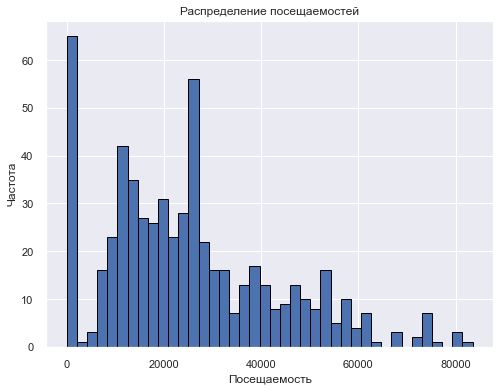

In [680]:
plt.figure(figsize=(8, 6))
plt.title('Распределение посещаемостей')
plt.xlabel('Посещаемость')
plt.ylabel('Частота')
df['Attendance'].hist(bins=40, edgecolor='black');

Ого! Надо будет не забыть подумать, откуда такое количество в левом столбце...

Что за грубияны с пятнадцатью красными карточками за сезон?!


In [681]:
df[df['Performance: CrdR'] == 15]

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
125,6,Betis,38,0.45,0.24,0.32,1.08,0.13,1.58,1.32,...,4,3,1,50.47,11.92,47.4,9.58,27.08,22.55,0.18


При этом они заняли шестое место...

А еще кто-то выигрывал всего 5% игр за сезон! Кто же это?

In [682]:
df[df['W (per game)'] == 0.05] # неудивительно, что они вылетели (заняли 20 место и перешли в лигу ниже)... 

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
567,20,Chievo,38,0.05,0.37,0.58,1.97,-1.32,0.45,1.59,...,3,4,2,51.16,18.29,48.7,12.39,28.79,26.0,0.47


In [683]:
round(df.iloc[:, 20:40].describe(), 2)

,Progression: PrgC (per game),Progression: PrgP,Per 90 Minutes: Gls,Per 90 Minutes: Ast,Per 90 Minutes: G+A,Per 90 Minutes: G-PK,Per 90 Minutes: G+A-PK,Per 90 Minutes: xG,Per 90 Minutes: xAG,Per 90 Minutes: xG+xAG,Per 90 Minutes: npxG,Per 90 Minutes: npxG+xAG,Performance: Saves (per game),Performance: Save%,Performance: CS%,Penalty Kicks: PKatt,Penalty Kicks: PKA,Penalty Kicks: PKsv,Penalty Kicks: PKm,Penalty Kicks: Save%
count,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00
mean,17.90,38.45,1.35,0.94,2.28,1.22,2.15,1.35,0.95,2.30,1.22,2.18,2.88,70.52,26.71,6.05,4.75,0.97,0.34,16.89
std,4.16,8.44,0.45,0.35,0.79,0.43,0.77,0.34,0.27,0.60,0.32,0.58,0.56,4.79,10.28,2.73,2.41,1.00,0.59,17.54
min,9.08,22.21,0.50,0.32,0.84,0.42,0.74,0.76,0.51,1.28,0.67,1.18,1.41,52.70,2.60,0.00,0.00,0.00,0.00,0.00
25%,14.89,32.65,1.03,0.68,1.71,0.92,1.61,1.10,0.76,1.87,0.99,1.75,2.49,67.30,18.40,4.00,3.00,0.00,0.00,0.00
50%,17.66,36.92,1.26,0.87,2.13,1.15,2.00,1.28,0.89,2.18,1.15,2.05,2.85,70.60,26.30,6.00,5.00,1.00,0.00,14.30
75%,20.32,42.82,1.58,1.12,2.71,1.45,2.58,1.51,1.09,2.60,1.37,2.46,3.26,73.70,32.40,8.00,6.00,1.00,1.00,25.00
max,34.87,68.62,2.88,2.24,5.09,2.68,4.88,2.75,2.15,4.78,2.51,4.64,4.76,83.70,68.40,16.00,15.00,5.00,3.00,100.00


Посмотрим на команды с худшим (52,7% отраженных ударов) и лучшим (83,7% отраженных ударов) вратарем.

In [684]:
df[df['Performance: Save%'] == 52.7] # кошмар...

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
19,20,Southampton,38,0.16,0.18,0.66,1.92,-0.97,0.66,1.61,...,3,3,5,56.05,14.5,47.4,11.26,30.03,22.42,0.26


In [685]:
df[df['Performance: Save%'] == 83.7] # круто!

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
221,2,Atlético Madrid,38,0.61,0.26,0.13,0.58,0.95,2.08,0.94,...,4,4,1,58.26,14.58,50.7,13.5,37.63,23.29,0.11


In [686]:
round(df.iloc[:, 40:60].describe(), 2)

,Standard: SoT%,Standard: Sh/90,Standard: SoT/90,Standard: G/Sh,Standard: G/SoT,Standard: Dist,Standard: FK,Standard: PK,Standard: PKatt,Expected: npxG/Sh,Expected: G-xG,Expected: np:G-xG,Total: Cmp (per game),Total: Att (per game),Total: Cmp%,Total: TotDist (per game),Total: PrgDist (per game),Short: Cmp (per game),Short: Att (per game),Short: Cmp%
count,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00
mean,33.05,12.32,4.10,0.10,0.29,18.04,0.49,4.75,6.06,0.10,-0.14,-0.21,387.13,493.39,77.72,6924.18,2553.82,173.24,198.20,86.75
std,3.35,2.14,0.95,0.02,0.05,1.06,0.19,2.51,2.93,0.01,7.29,7.22,89.82,84.81,4.87,1354.24,300.51,48.61,48.83,3.14
min,25.10,6.97,2.13,0.04,0.15,15.10,0.09,0.00,0.00,0.06,-18.30,-17.20,188.68,308.29,60.70,3644.74,1761.61,82.71,107.66,75.00
25%,30.88,10.86,3.42,0.08,0.26,17.30,0.37,3.00,4.00,0.09,-5.40,-5.20,325.99,434.34,74.68,5963.40,2343.48,137.59,162.39,84.70
50%,32.90,11.96,3.92,0.10,0.29,18.00,0.47,4.00,6.00,0.10,-0.65,-0.80,367.17,474.22,77.80,6711.86,2506.91,161.08,186.46,86.95
75%,35.22,13.45,4.62,0.11,0.33,18.80,0.58,6.00,8.00,0.11,4.60,4.10,433.89,539.89,81.00,7638.52,2744.64,196.75,221.56,88.90
max,45.90,19.65,7.50,0.19,0.45,20.90,1.58,15.00,20.00,0.16,26.70,28.60,688.53,788.45,89.50,11706.15,3881.15,371.97,401.97,93.60


Столбец "Expected: G-xG" показывает разницу между количеством забитых голов и количеством ожидаемых. Посмотрим на самую невезучую команду...

In [687]:
df[df['Expected: G-xG'] == -18.3] # а вот и самые невезучие команды за 6 сезонов в ведущих европейских лигах!

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
326,7,Nice,38,0.39,0.29,0.32,0.92,-0.13,1.47,1.32,...,7,6,1,51.50,13.58,50.7,11.84,29.26,20.45,0.29
578,11,Sassuolo,38,0.29,0.26,0.45,1.55,-0.79,1.13,1.29,...,6,3,2,54.66,15.58,52.9,13.32,28.26,28.55,0.42


In [688]:
df[df['Expected: G-xG'] == 26.7] # вот это им везло, однако!

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
568,1,Juventus,38,0.79,0.13,0.08,0.63,1.63,2.5,0.72,...,5,4,2,52.71,11.97,55.4,11.08,24.68,19.66,0.45


In [689]:
round(df.iloc[:, 60:80].describe(), 2) 

,Medium: Cmp (per game),Medium: Att (per game),Medium: Cmp%,Long: Cmp (per game),Long: Att (per game),Long: Cmp%,Unnamed: 21_level_0: KP,Unnamed: 22_level_0: 1/3,Unnamed: 23_level_0: PPA,Unnamed: 24_level_0: CrsPA,Pass Types: Live (per game),Pass Types: Dead (per game),Pass Types: FK (per game),Pass Types: TB (per game),Pass Types: Sw (per game),Pass Types: Crs (per game),Pass Types: TI (per game),Pass Types: CK (per game),Corner Kicks: In (per game),Corner Kicks: Out (per game)
count,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00
mean,157.82,186.37,83.99,43.83,79.35,55.27,340.44,1090.82,279.30,76.11,442.09,49.42,13.52,1.08,4.17,18.07,20.87,4.90,2.02,1.91
std,38.17,37.39,3.97,6.80,8.44,6.40,70.15,269.85,80.44,21.00,86.01,3.04,1.73,0.68,1.44,2.76,2.22,0.87,0.65,0.69
min,66.84,95.32,67.50,28.21,55.66,38.80,161.00,542.00,112.00,30.00,258.50,40.18,8.13,0.13,1.24,10.37,14.13,3.08,0.24,0.03
25%,130.15,158.96,81.47,39.14,73.54,50.90,290.75,908.00,223.75,61.00,383.29,47.37,12.29,0.61,3.16,16.12,19.32,4.32,1.61,1.45
50%,152.33,181.09,84.40,43.38,78.33,54.80,329.50,1026.00,261.50,75.00,421.85,49.71,13.58,0.92,4.02,17.98,20.92,4.82,1.94,1.86
75%,181.79,209.48,86.90,47.63,84.78,59.00,377.00,1209.00,323.00,89.00,488.10,51.50,14.74,1.34,4.98,19.74,22.30,5.39,2.42,2.29
max,290.59,324.00,92.80,77.91,117.74,74.20,582.00,2110.00,554.00,164.00,741.53,58.97,19.68,5.68,11.71,28.74,28.79,8.44,4.16,5.45


In [690]:
round(df.iloc[:, 80:100].describe(), 2)

,Corner Kicks: Str (per game),Outcomes: Blocks (per game),SCA: SCA90,SCA Types: PassLive (per game),SCA Types: PassDead (per game),SCA Types: TO (per game),SCA Types: Sh (per game),SCA Types: Fld (per game),SCA Types: Def (per game),GCA: GCA90,GCA Types: PassLive (per game),GCA Types: PassDead (per game),GCA Types: TO (per game),GCA Types: Sh (per game),GCA Types: Fld (per game),GCA Types: Def (per game),Tackles: Tkl (per game),Tackles: TklW (per game),Tackles: Def 3rd (per game),Tackles: Mid 3rd (per game)
count,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00
mean,0.08,9.23,21.81,15.66,1.98,1.33,1.28,1.21,0.36,2.32,0.68,0.07,0.07,0.09,0.08,0.02,16.39,9.98,7.93,6.51
std,0.14,1.21,4.06,3.45,0.40,0.40,0.35,0.27,0.12,0.81,0.06,0.03,0.03,0.03,0.03,0.02,1.88,1.58,1.24,0.97
min,0.00,6.03,12.11,8.37,1.00,0.37,0.43,0.55,0.11,0.71,0.48,0.00,0.00,0.00,0.00,0.00,12.00,6.63,4.82,4.29
25%,0.00,8.34,18.93,13.12,1.71,1.05,1.05,1.00,0.29,1.71,0.64,0.05,0.05,0.06,0.05,0.00,15.05,8.88,7.06,5.82
50%,0.03,9.11,21.05,14.98,1.97,1.27,1.24,1.21,0.34,2.16,0.68,0.07,0.07,0.08,0.07,0.01,16.27,9.79,7.92,6.45
75%,0.09,9.97,23.85,17.51,2.24,1.58,1.47,1.38,0.45,2.74,0.72,0.09,0.09,0.11,0.10,0.02,17.59,10.87,8.79,7.11
max,1.79,14.26,35.68,27.50,3.08,2.82,2.74,2.26,0.79,5.18,0.85,0.18,0.19,0.20,0.20,0.08,24.13,16.16,11.63,9.79


Кто-то совершал более 24 отборов в среднем за игру. При среднем показателе в 16,4 это довольно много. По идее, это должна быть команда из нижней части таблицы, потому что они чаще обороняются и им приходится много отбирать мячи. Давайте проверим!

In [691]:
df[df['Tackles: Tkl (per game)'] == 24.13] # бойцы! кстати, Атлетико славится своей неуступчивостью.

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
221,2,Atlético Madrid,38,0.61,0.26,0.13,0.58,0.95,2.08,0.94,...,4,4,1,58.26,14.58,50.7,13.5,37.63,23.29,0.11


Не... Команда заняла второе место. Но это Атлетико, так что ничего удивительного.

In [692]:
round(df.iloc[:, 100:120].describe(), 2)

,Tackles: Att 3rd (per game),Challenges: Tkl (per game),Challenges: Att (per game),Challenges: Tkl%,Challenges: Lost (per game),Blocks: Blocks (per game),Blocks: Sh (per game),Blocks: Pass (per game),Touches: Touches (per game),Touches: Def Pen (per game),Touches: Def 3rd (per game),Touches: Mid 3rd (per game),Touches: Att 3rd (per game),Touches: Att Pen (per game),Take-Ons: Att (per game),Take-Ons: Succ%,Take-Ons: Tkld (per game),Take-Ons: Tkld%,Carries: Carries (per game),Carries: TotDist (per game)
count,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00
mean,1.95,6.99,16.18,43.19,9.19,10.70,3.06,7.64,602.55,60.48,188.98,279.23,140.42,20.15,16.55,55.61,6.99,42.34,338.44,1820.02
std,0.41,1.16,1.95,4.84,1.36,1.34,0.70,1.12,82.16,6.96,19.35,50.87,30.32,4.88,2.92,6.55,1.37,4.78,76.46,393.97
min,0.89,4.08,9.66,31.20,4.42,6.92,1.39,4.89,420.50,39.05,123.39,172.21,91.71,10.84,9.08,38.40,3.34,28.40,163.71,1036.97
25%,1.66,6.16,14.86,39.78,8.25,9.74,2.58,6.87,546.50,55.34,174.85,242.20,119.18,16.63,14.55,51.90,6.03,39.30,281.64,1538.38
50%,1.92,6.89,16.10,42.75,9.14,10.63,3.00,7.47,584.30,60.24,188.78,269.93,133.04,19.06,16.26,56.45,6.91,42.30,326.64,1758.32
75%,2.21,7.71,17.42,46.22,10.03,11.61,3.48,8.32,646.99,65.62,202.04,304.92,153.66,22.72,18.39,60.30,7.79,45.40,378.18,2043.57
max,3.55,10.84,23.32,60.80,13.74,14.76,5.84,11.68,884.95,82.24,247.50,488.55,262.24,39.45,26.82,71.50,12.47,60.50,656.61,3396.66


Какая-то команда боится мяча как огня! Они несли его в ногах чуть больше чем на километр в среднем на игру, что почти в два раза меньше, чем в среднем по всем наблюдениям. Кто же это был?

In [693]:
df[df['Carries: TotDist (per game)'] == 1036.97] # совсем не жаль, что они вылетели  

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
97,18,Cardiff City,38,0.26,0.11,0.63,1.82,-0.92,0.89,1.62,...,2,7,0,51.97,25.42,50.0,13.92,31.16,27.21,0.47


In [694]:
round(df.iloc[:, 120:].describe(), 2)

,Carries: PrgDist (per game),Carries: 1/3 (per game),Carries: CPA (per game),Receiving: Rec (per game),Receiving: PrgR (per game),Performance: 2CrdY,Performance: Fls (per game),Performance: Fld (per game),Performance: Off (per game),Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
count,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.00,588.0,588.00,588.00,588.00,588.00
mean,938.15,13.37,4.21,384.07,38.10,1.61,12.45,11.80,1.88,4.54,6.06,1.54,53.22,15.96,50.1,10.66,27.05,20.04,0.34
std,225.89,3.31,1.43,89.53,8.41,1.38,1.75,1.58,0.44,2.49,2.74,1.22,3.93,3.51,3.2,1.63,2.92,4.15,0.13
min,497.53,6.59,1.68,186.26,21.74,0.00,8.29,7.26,0.79,0.00,0.00,0.00,38.00,6.45,41.1,5.87,18.26,10.58,0.03
25%,775.58,10.95,3.12,323.64,32.24,1.00,11.21,10.70,1.56,3.00,4.00,1.00,50.78,13.34,47.8,9.53,24.86,17.40,0.24
50%,911.32,12.95,3.97,364.26,36.58,1.00,12.53,11.95,1.87,4.00,6.00,1.00,53.10,15.84,50.1,10.67,26.98,20.04,0.32
75%,1071.00,14.97,5.06,430.59,42.46,2.00,13.58,12.87,2.18,6.00,8.00,2.00,55.62,18.09,52.2,11.74,28.96,22.58,0.44
max,1794.66,26.76,10.16,684.82,68.06,6.00,18.58,17.50,3.61,15.00,16.00,6.00,66.21,26.74,59.5,15.34,37.63,34.42,0.87


Вау! Кто-то умудрился забить 6 автоголов за сезон!

In [695]:
df[df['Performance: OG'] == 6] # неудачники...

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKwon,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game)
5,6,Brighton,38,0.47,0.21,0.32,1.39,0.50,1.63,1.32,...,4,8,6,52.97,11.68,53.4,7.97,24.18,11.37,0.39
501,14,Empoli,38,0.26,0.29,0.45,1.84,-0.53,1.08,1.74,...,6,10,6,52.58,11.24,43.8,9.26,24.21,20.32,0.26
525,18,Benevento,38,0.18,0.32,0.50,1.97,-0.92,0.87,1.69,...,7,5,6,46.03,13.05,44.6,10.08,23.53,19.63,0.34


__Мы хотим заменить столбец со ссылками на столбец с сезонами, где будут указаны года.__ Это понадобится нам как для визуализаций, так и для проверки гипотез.

In [696]:
leagues_url_list = df['League URL'].to_list()
leagues_url_list[::30] # смотрим на данные

['https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/2021-2022/2021-2022-Premier-League-Stats',
 'https://fbref.com/en/comps/9/2019-2020/2019-2020-Premier-League-Stats',
 'https://fbref.com/en/comps/9/2018-2019/2018-2019-Premier-League-Stats',
 'https://fbref.com/en/comps/12/La-Liga-Stats',
 'https://fbref.com/en/comps/12/2021-2022/2021-2022-La-Liga-Stats',
 'https://fbref.com/en/comps/12/2019-2020/2019-2020-La-Liga-Stats',
 'https://fbref.com/en/comps/12/2018-2019/2018-2019-La-Liga-Stats',
 'https://fbref.com/en/comps/13/Ligue-1-Stats',
 'https://fbref.com/en/comps/13/2021-2022/2021-2022-Ligue-1-Stats',
 'https://fbref.com/en/comps/13/2019-2020/2019-2020-Ligue-1-Stats',
 'https://fbref.com/en/comps/13/2018-2019/2018-2019-Ligue-1-Stats',
 'https://fbref.com/en/comps/20/Bundesliga-Stats',
 'https://fbref.com/en/comps/20/2021-2022/2021-2022-Bundesliga-Stats',
 'https://fbref.com/en/comps/20/2019-2020/2019-2020-Bundesliga-Stats',
 'https://fbref.com/en/comp

In [697]:
seasons_list = []
for url in leagues_url_list:
    url_splitted = url.split('/')
    if len(url_splitted[-2]) != 9: # это для новейшего сезона - там в ссылке нет года, поэтому вручную добавляем его
        seasons_list.append('2022-2023')
    else:
        seasons_list.append(url_splitted[-2]) 

In [698]:
df['League URL'] = seasons_list # заменяем данные в датасете

In [699]:
df.rename({'League URL': 'Season'}, axis=1, inplace=True)
df.iloc[:, :20].head() # убеждаемся, что все норм

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),xGD/90,Attendance,Top Team Scorer (per game),Season,Pl,Age,Poss,Performance: PKatt,Performance: CrdY (per game),Performance: CrdR
0,1,Manchester City,38,0.74,0.13,0.13,0.87,1.61,2.34,0.84,1.23,53249.0,0.947368,2022-2023,24,27.2,64.7,10,1.16,1.0
1,2,Arsenal,38,0.68,0.16,0.16,1.13,1.18,2.21,1.11,0.79,60191.0,0.394737,2022-2023,26,24.7,59.3,4,1.34,0.0
2,3,Manchester Utd,38,0.61,0.16,0.24,1.13,0.39,1.97,1.33,0.45,73671.0,0.447368,2022-2023,26,26.9,53.7,3,2.05,2.0
3,4,Newcastle Utd,38,0.50,0.37,0.13,0.87,0.92,1.87,1.04,0.85,52127.0,0.473684,2022-2023,27,27.3,52.3,6,1.61,1.0
4,5,Liverpool,38,0.50,0.26,0.24,1.24,0.74,1.76,1.34,0.57,53163.0,0.500000,2022-2023,28,27.4,60.8,4,1.50,1.0


In [700]:
df['Top Team Scorer (per game)'] = round(df['Top Team Scorer (per game)'], 2)

In [701]:
leagues_url_list

['https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps/9/Premier-League-Stats',
 'https://fbref.com/en/comps

__Теперь хотим достать название лиг в отдельную колонку,__ чтобы тоже использовать в дальнейшем

In [702]:
leagues_list = []
for url in leagues_url_list:
    url_splitted = url.split('/')
    last_string = url_splitted[-1].split('-')
    if len(last_string) == 3 or len(last_string) == 2: # случай последнего сезона
        league = ' '.join(last_string[:-1])
    else:
        league = ' '.join(last_string[2:-1])
    leagues_list.append(league)

In [703]:
df['League'] = leagues_list
df.head()

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game),League
0,1,Manchester City,38,0.74,0.13,0.13,0.87,1.61,2.34,0.84,...,3,1,49.11,11.53,54.6,5.87,18.26,10.58,0.21,Premier League
1,2,Arsenal,38,0.68,0.16,0.16,1.13,1.18,2.21,1.11,...,5,1,52.21,12.79,46.5,6.24,21.18,15.76,0.58,Premier League
2,3,Manchester Utd,38,0.61,0.16,0.24,1.13,0.39,1.97,1.33,...,3,1,57.63,12.24,51.7,9.26,26.58,20.29,0.26,Premier League
3,4,Newcastle Utd,38,0.50,0.37,0.13,0.87,0.92,1.87,1.04,...,5,2,54.34,14.55,56.4,8.76,24.74,17.89,0.26,Premier League
4,5,Liverpool,38,0.50,0.26,0.24,1.24,0.74,1.76,1.34,...,4,2,58.18,12.68,51.4,8.76,24.29,14.95,0.50,Premier League


In [704]:
df.tail()

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: PKcon,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game),League
583,16,Cagliari,38,0.29,0.16,0.55,1.61,-0.74,1.03,1.56,...,12,1,50.03,19.55,55.3,11.34,28.18,26.79,0.11,Serie A
584,17,SPAL,38,0.21,0.37,0.42,1.55,-0.53,1.00,1.52,...,12,4,46.74,13.34,48.2,13.87,29.29,29.24,0.29,Serie A
585,18,Crotone,38,0.24,0.21,0.55,1.74,-0.68,0.92,1.54,...,8,0,55.32,16.32,45.5,15.21,33.55,32.45,0.26,Serie A
586,19,Hellas Verona,38,0.18,0.11,0.71,2.05,-1.26,0.66,1.85,...,8,2,49.55,14.61,46.4,14.24,31.71,29.29,0.63,Serie A
587,20,Benevento,38,0.16,0.08,0.76,2.21,-1.34,0.55,1.93,...,13,2,49.79,10.79,45.0,11.82,27.11,24.34,0.66,Serie A


__Создадим новый признак__ - вылетела ли команда. В немецком чемпионате команда "понижается в классе", если занимает 17 или 18 место. В остальных чемпионатов для того, чтобы перейти в низжий дивизион, нужно закончить восемнадцатыми, девятнадцатыми или двадцатыми.

In [705]:
df['Relegated'] = (((df['League'] == 'Bundesliga') & ((df['Rk'] == 17) | (df['Rk'] == 18))) |
                   ((df['League'] != 'Bundesliga') & ((df['Rk'] == 18) | (df['Rk'] == 19) | (df['Rk'] == 20)))).astype(int)

Готово! Потом мы, например, сможем предсказывать, вылетела команда или нет.

Выгрузим нашу финальную табличку с обработанными старыми признаками и созданными новыми.

In [706]:
df.to_csv('final_football_file.csv')

## Визуализация

__Для начала нарисуем несколько базовых диаграмм рассеяния, чтобы посмотреть, коррелируют ли (если да, то каким образом) некоторые интересующие нас признаки.__

In [707]:
# подгружаем нужные библиотеки
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use("seaborn")

%pylab inline

# Отключение некоторых лишних предупреждений
import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


Нам кажется, что если команда много забивает, ее вратарь должен иметь низкий процент отраженных ударов. Объяснение следующее: его команда атакует всю игру и в те редкие моменты, когда по их воротам бьют, вратарь оказывается недостаточно "в тонусе" и чаще пропускает, чем "размятые" вратари оборонительных команд. Посмотрим на картинку.

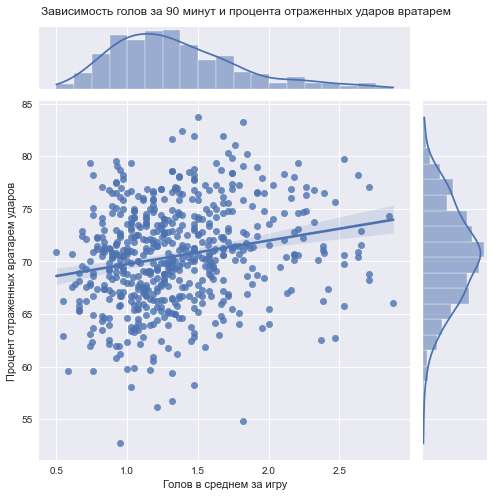

In [708]:
g = sns.jointplot(data=df, x='Per 90 Minutes: Gls', y='Performance: Save%', kind='reg', height=7)
g.fig.suptitle('Зависимость голов за 90 минут и процента отраженных ударов вратарем', size=12)
g.fig.subplots_adjust(top=0.94)
g.set_axis_labels('Голов в среднем за игру', 'Процент отраженных вратарем ударов');

Мы видим, что наша гипотеза не подтвердилась. Зависимость слабая, но все же положительная. <br>
Заметный выброс снизу мы рассмотрели выше - это "Саутгемптон".

Теперь глянем на то, как связано число коротких передач и набранных очков в среднем за игру. <br>
Мы предполагаем, что чем больше таких пасов, тем успешнее выступает команда. Как правило, доминирующие команды играют именно в комбинационный футбол, т.е. с использованием коротких передач, и чаще выигрывают.

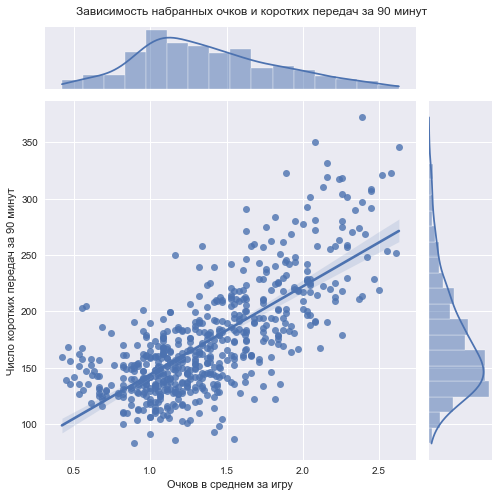

In [709]:
g = sns.jointplot(data=df, x='Pts/MP', y='Short: Cmp (per game)', kind='reg', height=7)
g.fig.suptitle('Зависимость набранных очков и коротких передач за 90 минут', size=12)
g.fig.subplots_adjust(top=0.94)
g.set_axis_labels('Очков в среднем за игру', "Число коротких передач за 90 минут");

Гипотеза подтвердилась.

Теперь глянем на то, как связано число уже длинных передач и набранных очков в среднем за игру. <br>
Гипотеза противоположная: чем больше таких пасов, тем меньше команда набирает баллов. Это предположение связано с тем, что обычно слабые команды играют в незамысловатый футбол, а это обычно выражается в "вертикальной" игре, т. е. с большим количеством передач на длинную дистанцию.

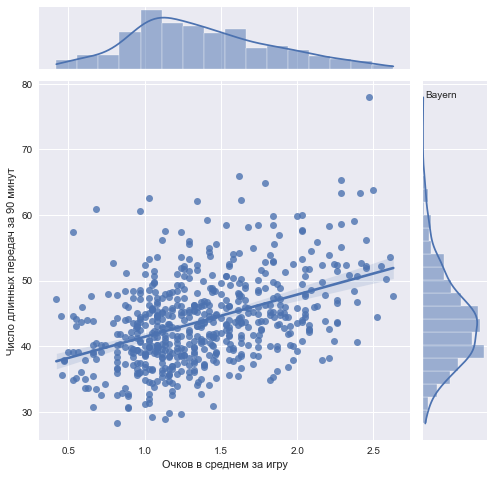

In [728]:
g = sns.jointplot(data=df, x='Pts/MP', y='Long: Cmp (per game)', kind='reg', height=7)
plt.annotate('Bayern', xy=(x, y), xytext=(x+0.00015, y))
g.fig.subplots_adjust(top=0.94)
g.set_axis_labels('Очков в среднем за игру', 'Число длинных передач за 90 минут');

Гипотеза не подтвердилась - связь положительная.

In [711]:
df[df['Long: Cmp (per game)'] == df['Long: Cmp (per game)'].max()] # глянули на выброс - это "Бавария"

,Rk,Squad,MP,W (per game),D (per game),L (per game),GA (per game),GD (per game),Pts/MP,xGA (per game),...,Performance: OG,Performance: Recov (per game),Aerial Duels: Won (per game),Aerial Duels: Won%,Int (per game),Tkl+Int (per game),Clr (per game),Err (per game),League,Relegated
450,1,Bayern Munich,34,0.79,0.09,0.12,0.82,1.88,2.47,0.93,...,3,49.62,15.24,53.6,10.44,28.35,11.74,0.32,Bundesliga,0


Рассмотрим показатель разницы фактически забитых и ожидаемых голов. Нам кажется, что он должен быть нормально распределен - каким-то командам везет больше, каким-то меньше, но никакого смещения быть не должно. Проверим!

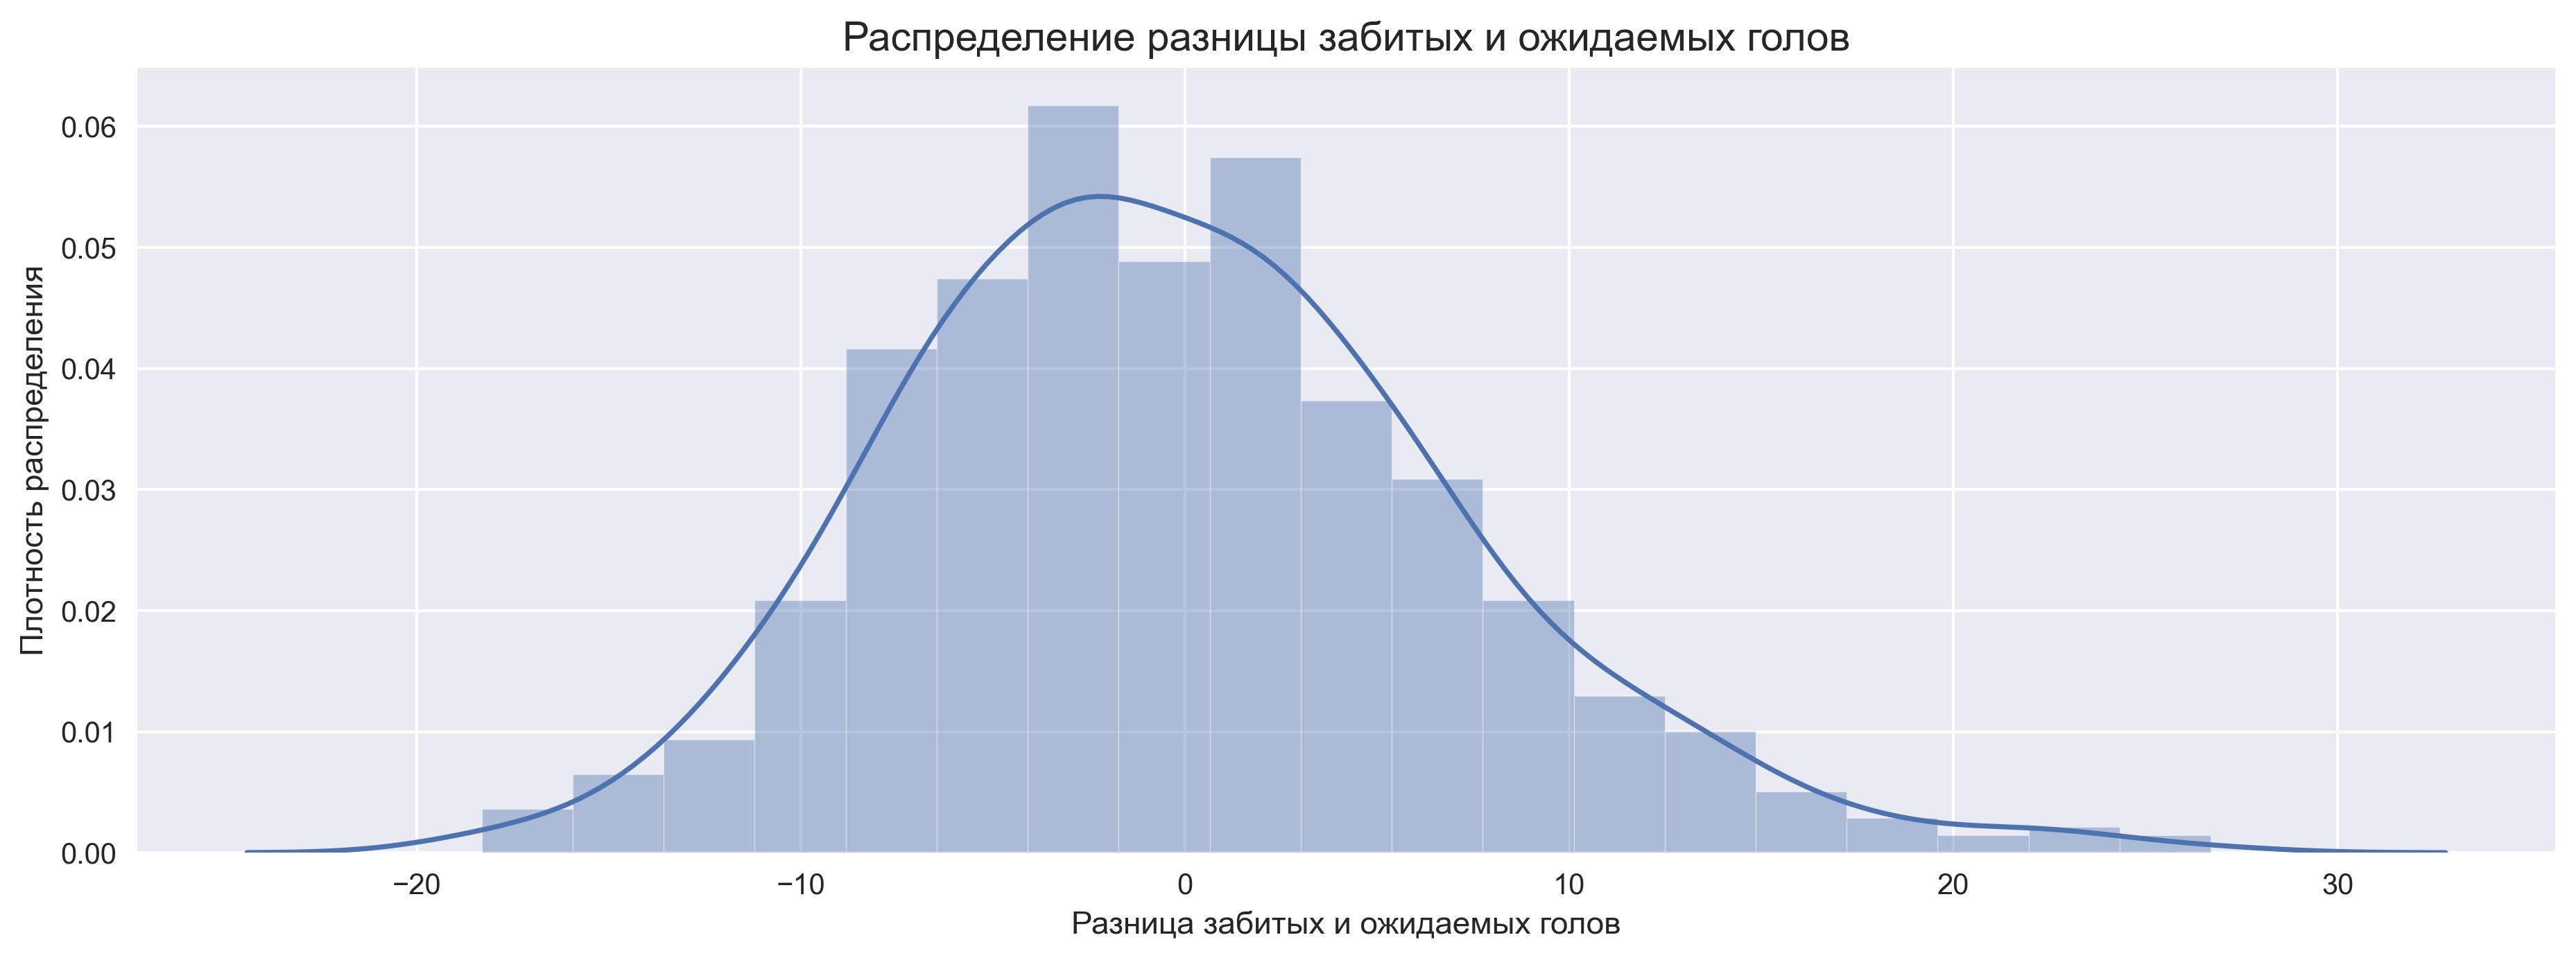

In [712]:
plt.figure(figsize=(15, 5), dpi=300)
plt.title('Распределение разницы забитых и ожидаемых голов', size=14)
sns.distplot(df['Expected: G-xG'])
plt.xlabel('Разница забитых и ожидаемых голов')
plt.ylabel('Плотность распределения')
plt.show()

Действительно, распределение похоже на нормальное. Проверим это в разделе с гипотезами...

Посмотрим на ящики с усами и виолончели.

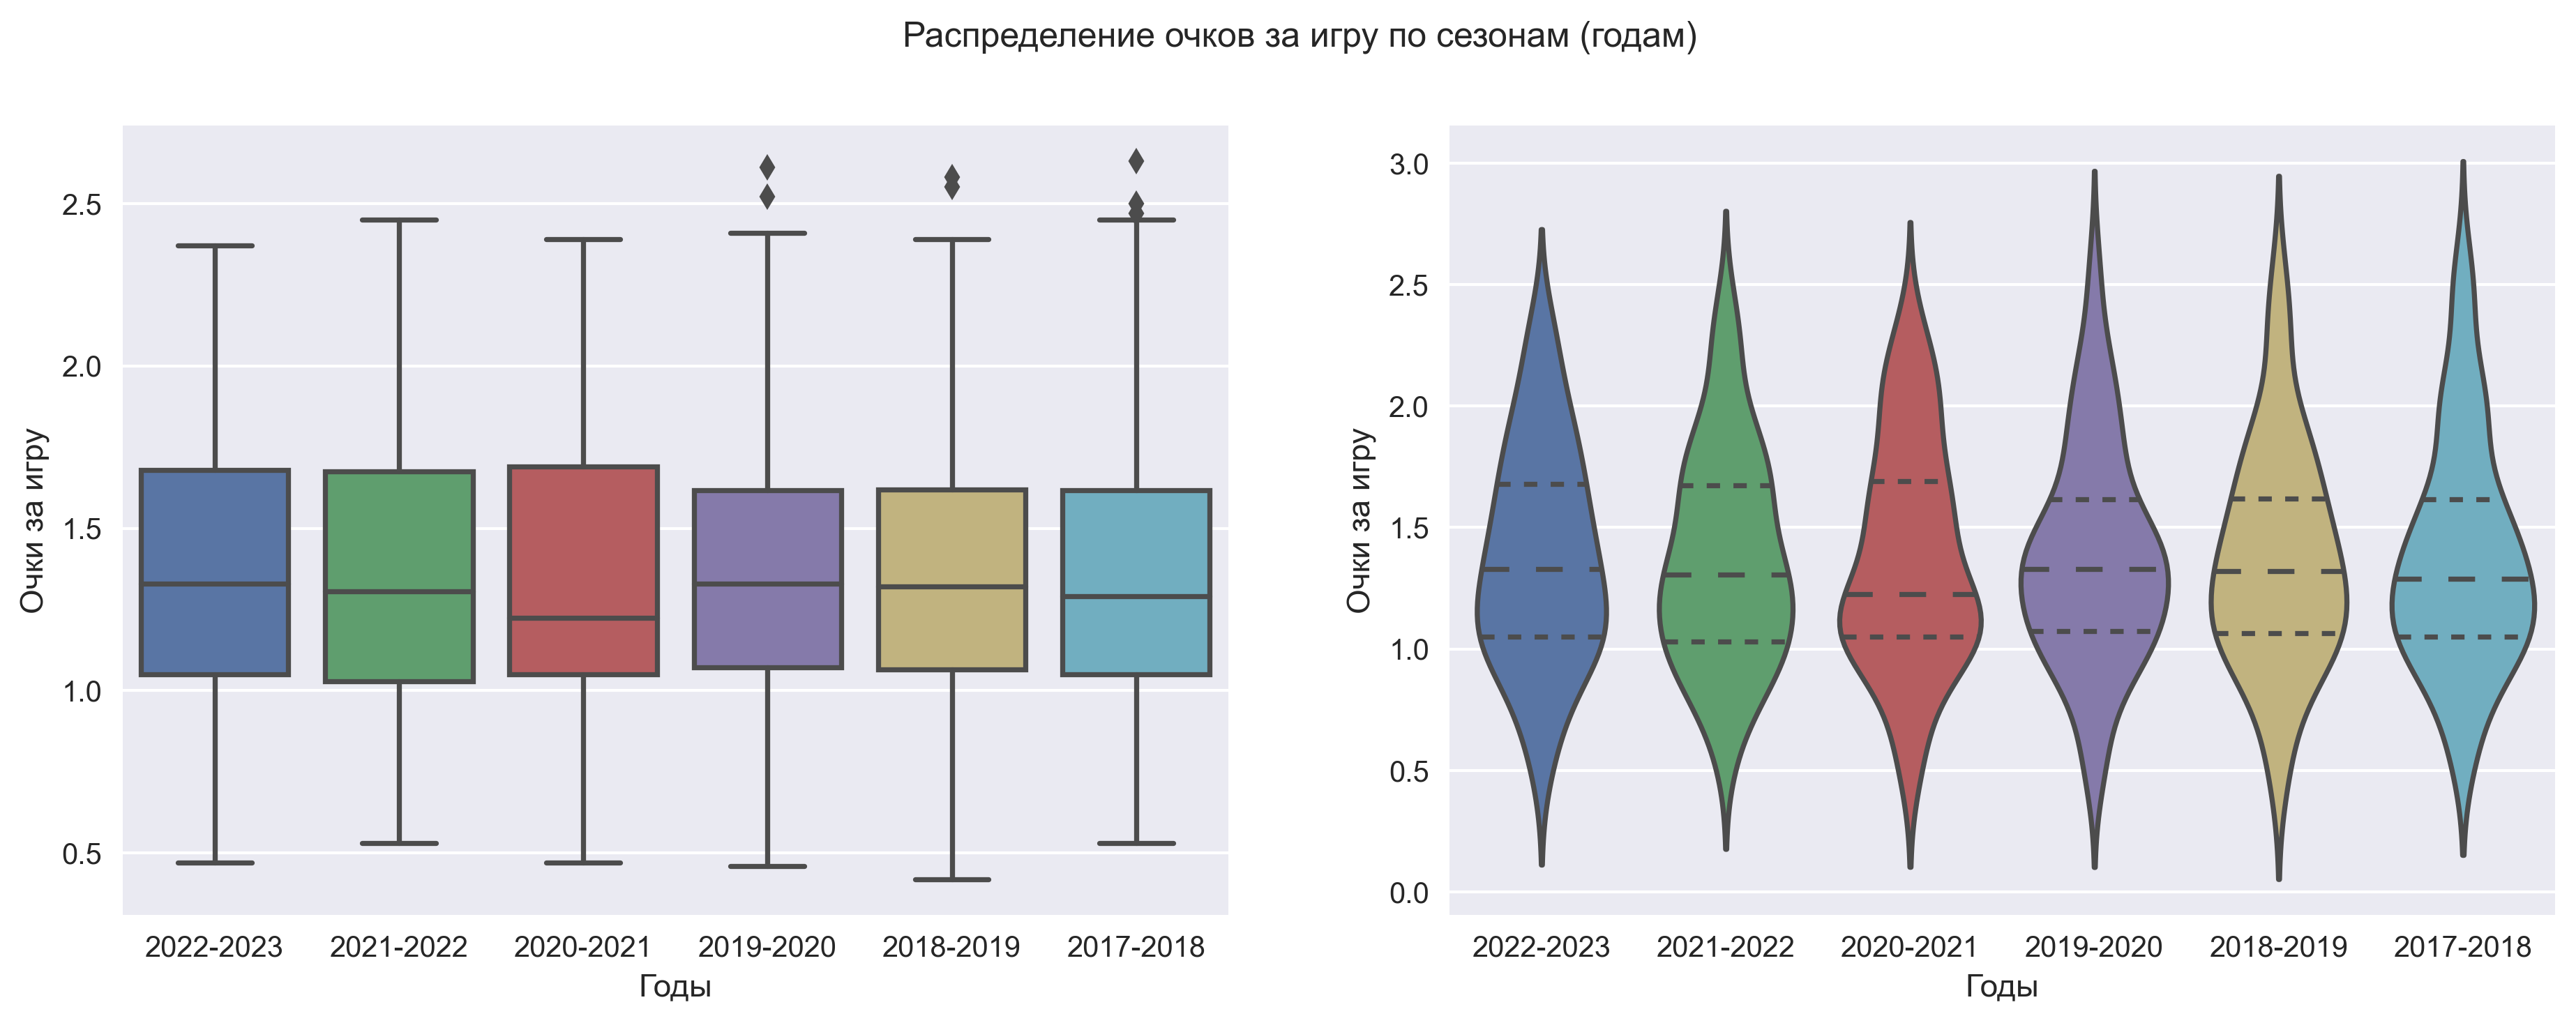

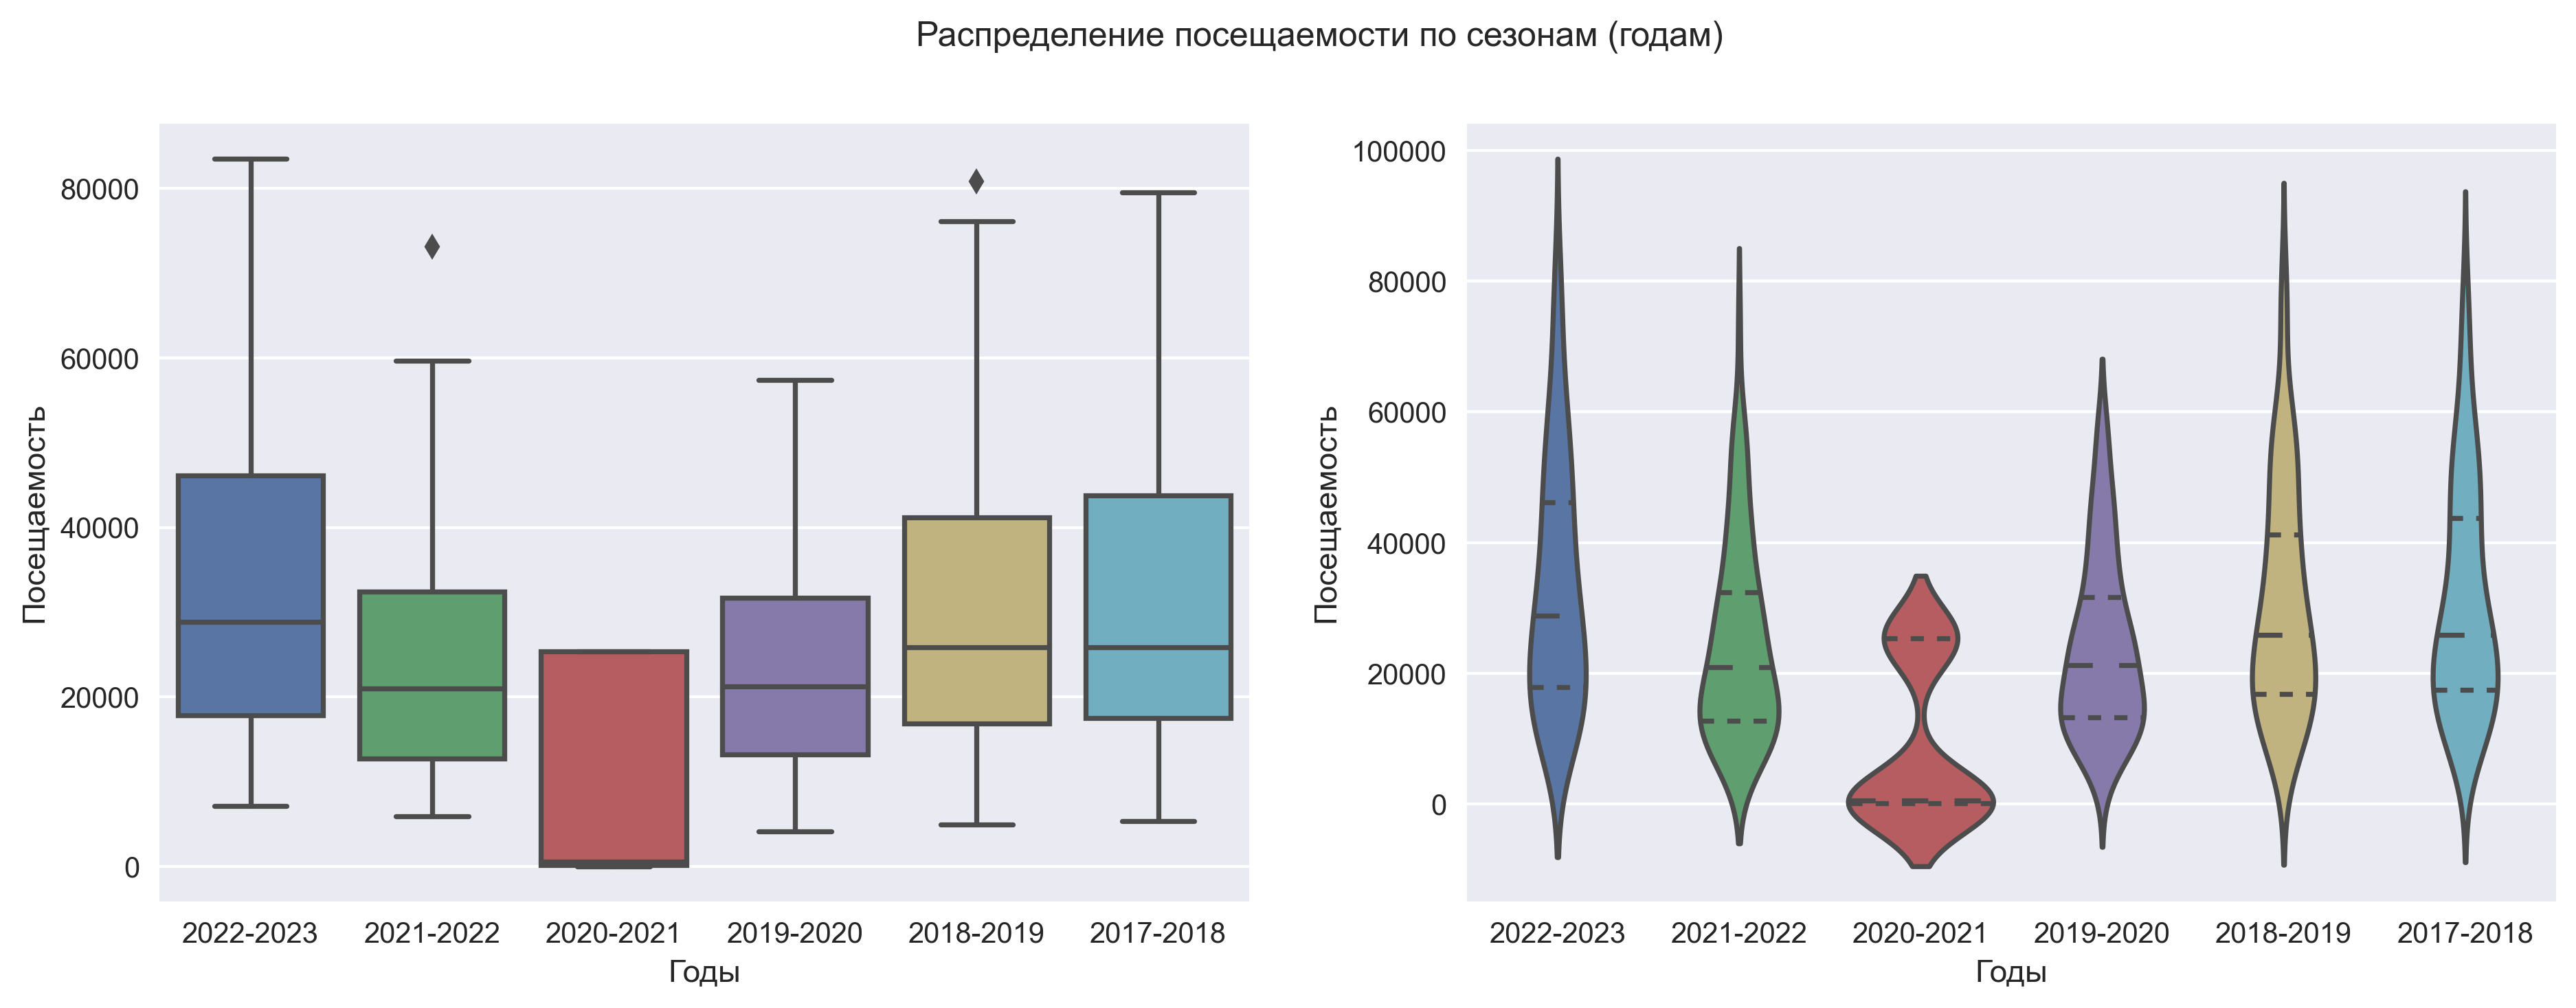

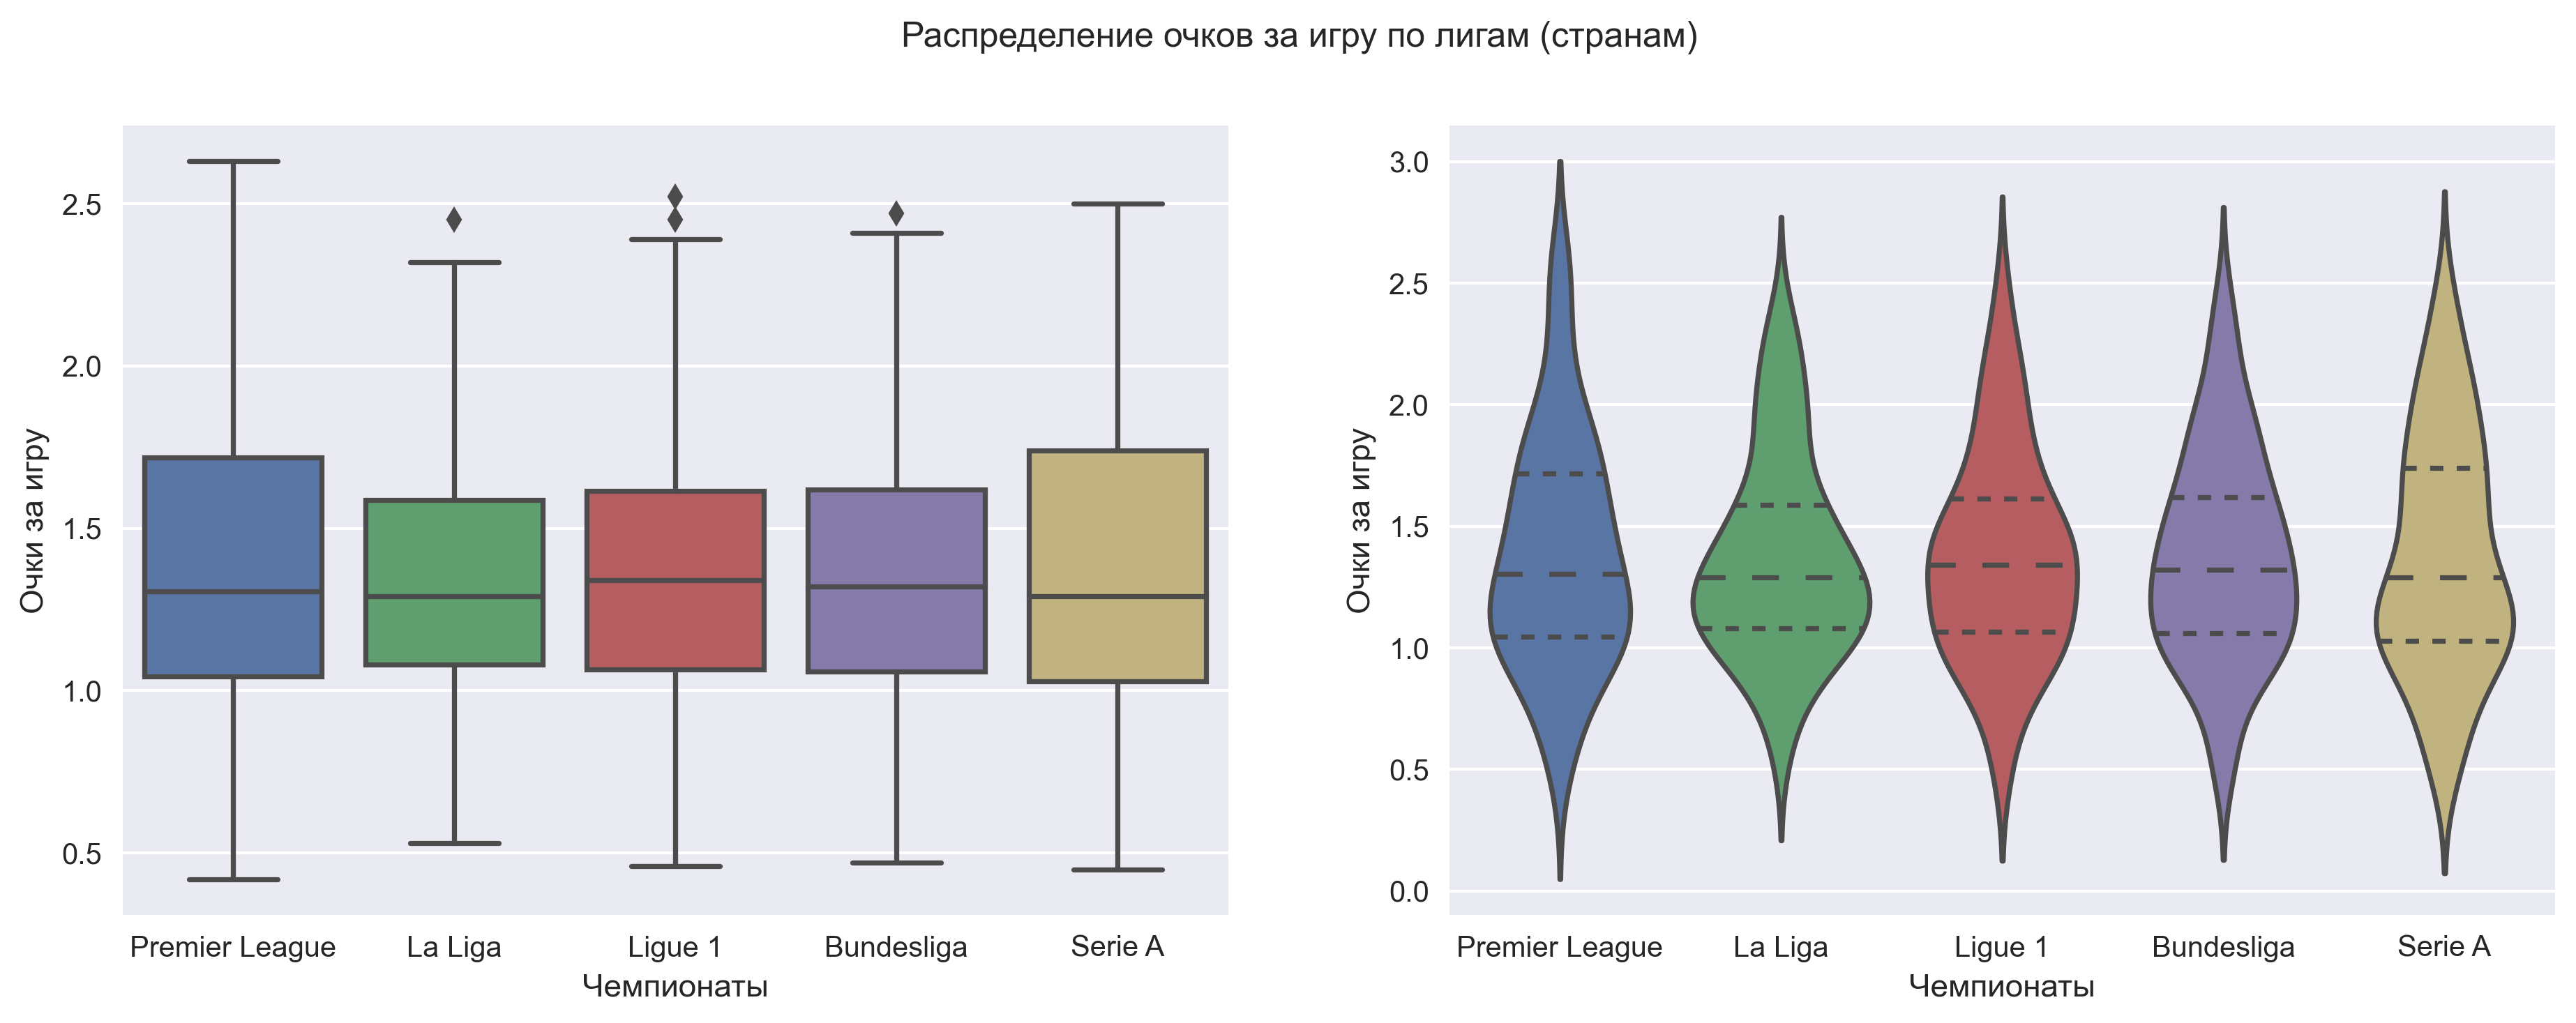

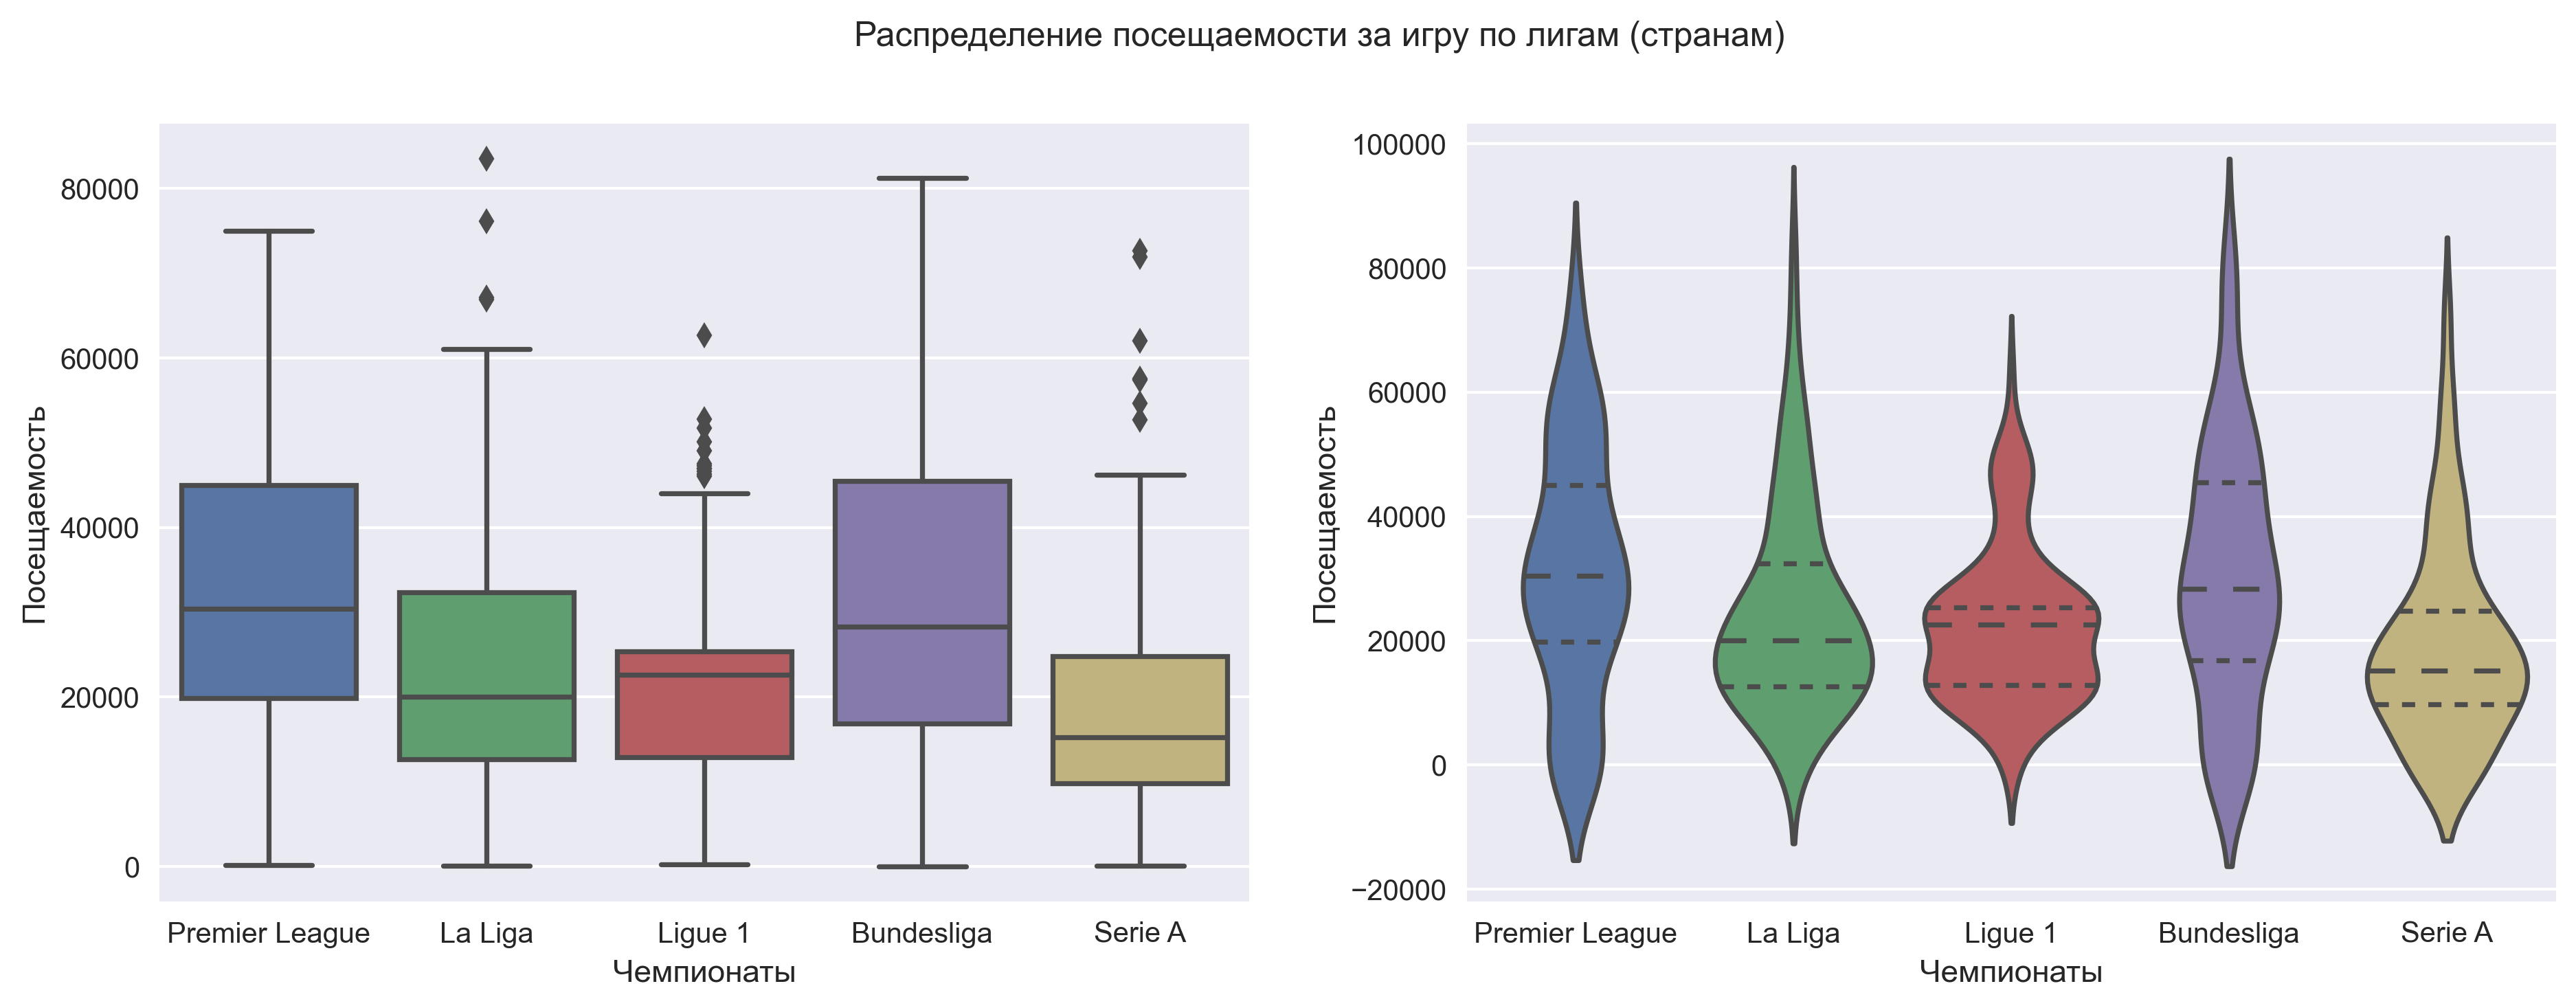

In [713]:
# распределение очков за игру по сезонам (годам)
plt.figure(figsize=(15, 5), dpi=300)
plt.suptitle('Распределение очков за игру по сезонам (годам)')
plt.subplot(1, 2, 1)
sns.boxplot(x='Season', y='Pts/MP', data=df)
plt.xlabel('Годы')
plt.ylabel('Очки за игру');
plt.subplot(1, 2, 2)
sns.violinplot(x='Season', 
               y='Pts/MP', 
               data=df, 
               inner="quartile")
plt.xlabel('Годы')
plt.ylabel('Очки за игру');

# распределение посещаемости по сезонам (годам)
plt.figure(figsize=(15, 5), dpi=300)
plt.suptitle('Распределение посещаемости по сезонам (годам)')
plt.subplot(1, 2, 1)
sns.boxplot(x='Season', y='Attendance', data=df)
plt.xlabel('Годы')
plt.ylabel('Посещаемость');
plt.subplot(1, 2, 2)
sns.violinplot(x='Season', 
               y='Attendance', 
               data=df, 
               inner="quartile")
plt.xlabel('Годы')
plt.ylabel('Посещаемость');

# распределение очков за игру по лигам (странам)
plt.figure(figsize=(15, 5), dpi=300)
plt.suptitle('Распределение очков за игру по лигам (странам)')
plt.subplot(1, 2, 1)
sns.boxplot(x='League', y='Pts/MP', data=df)
plt.xlabel('Чемпионаты')
plt.ylabel('Очки за игру');
plt.subplot(1, 2, 2)
sns.violinplot(x='League', 
               y='Pts/MP', 
               data=df, 
               inner="quartile")
plt.xlabel('Чемпионаты')
plt.ylabel('Очки за игру');

# распределение посещаемости за игру по лигам (странам)
plt.figure(figsize=(15, 5), dpi=300)
plt.suptitle('Распределение посещаемости за игру по лигам (странам)')
plt.subplot(1, 2, 1)
sns.boxplot(x='League', y='Attendance', data=df)
plt.xlabel('Чемпионаты')
plt.ylabel('Посещаемость');
plt.subplot(1, 2, 2)
sns.violinplot(x='League', 
               y='Attendance', 
               data=df, 
               inner="quartile")
plt.xlabel('Чемпионаты')
plt.ylabel('Посещаемость');

Теперь посмотрим на столбчатые диаграммы с теми же признаками.

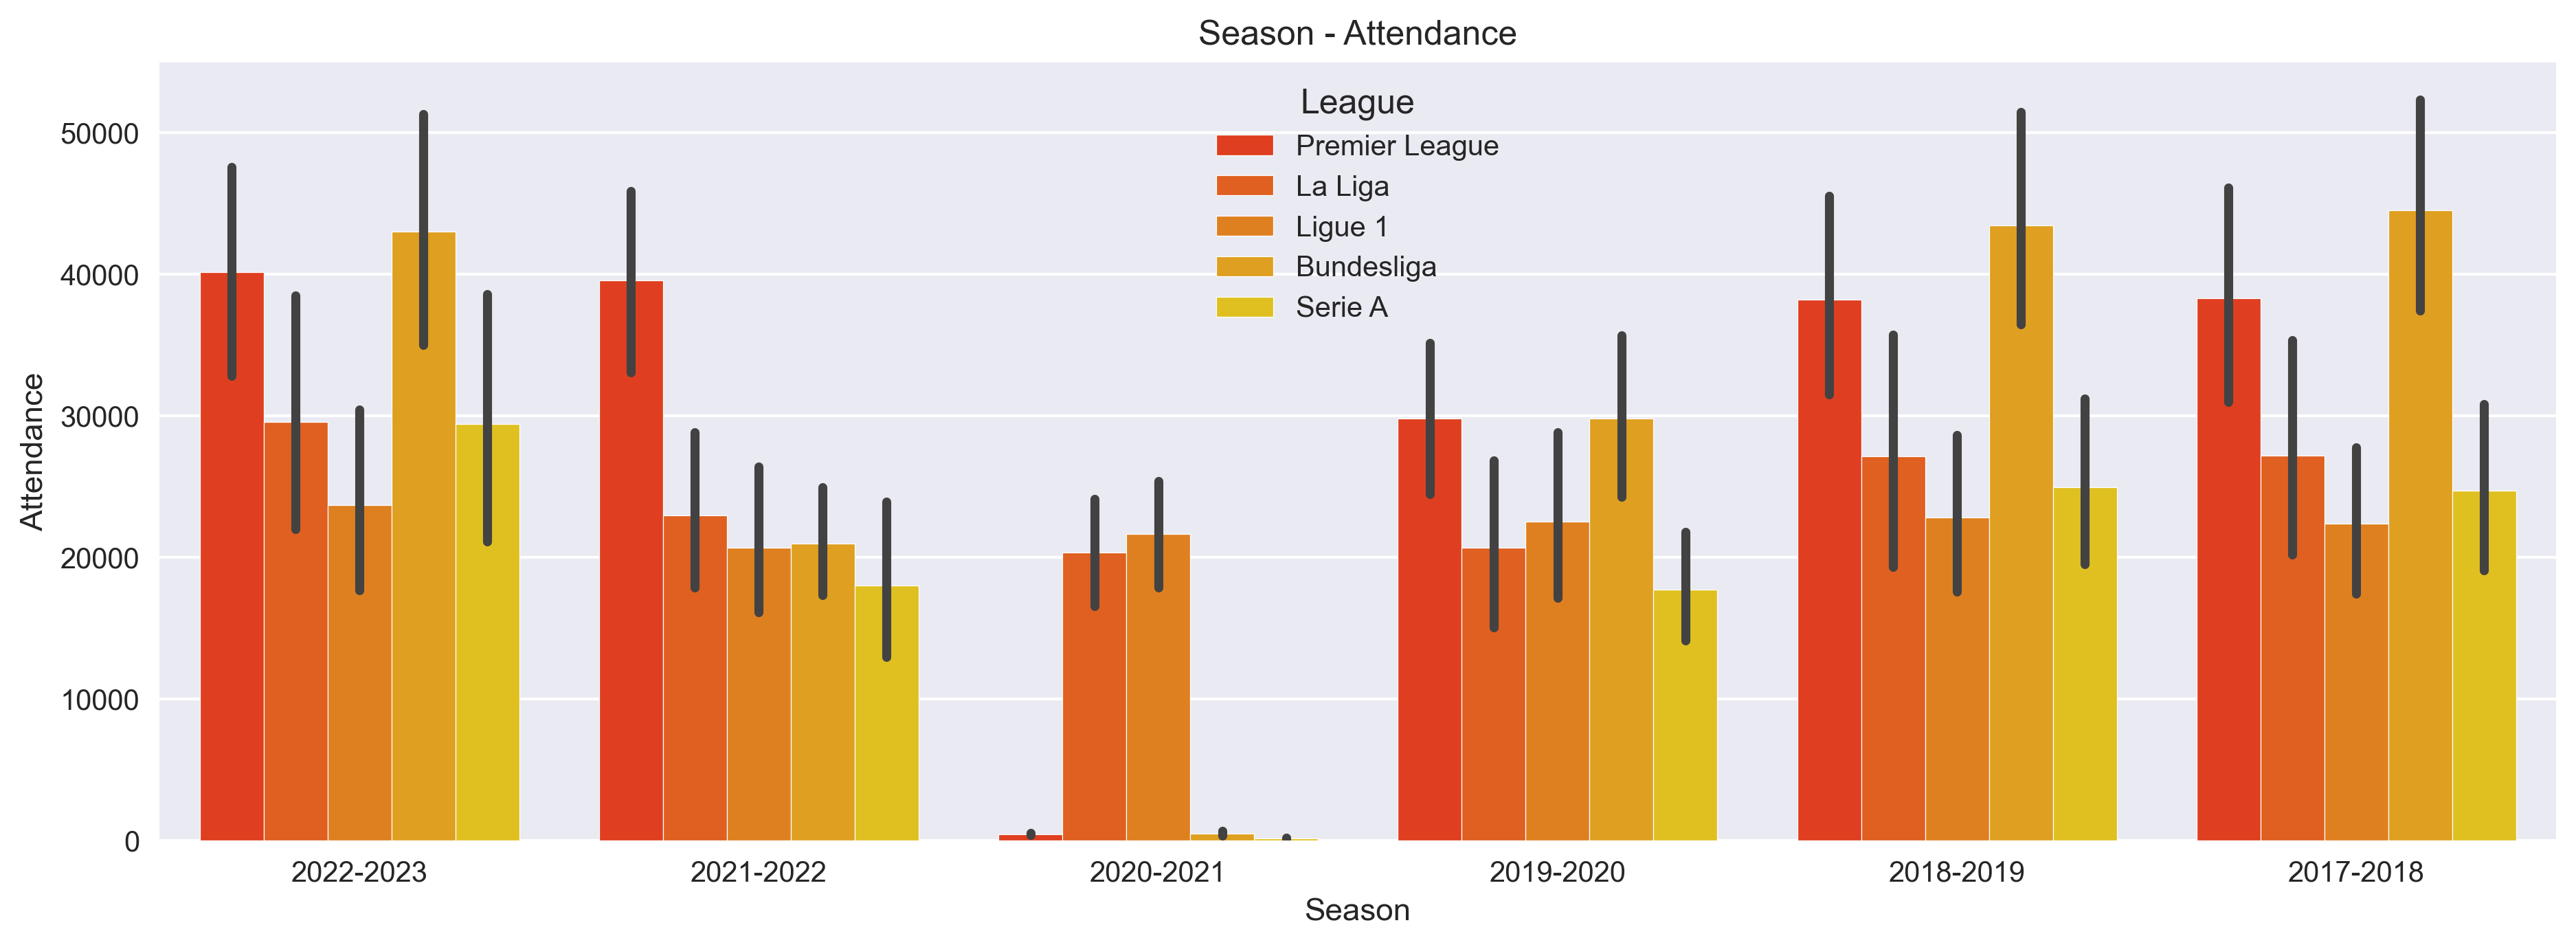

In [714]:
plt.figure(figsize=(15, 5), dpi=300)
sns.barplot(x='Season', y='Attendance', hue='League', data=df, palette='autumn')
plt.title('Season - Attendance')
plt.show()

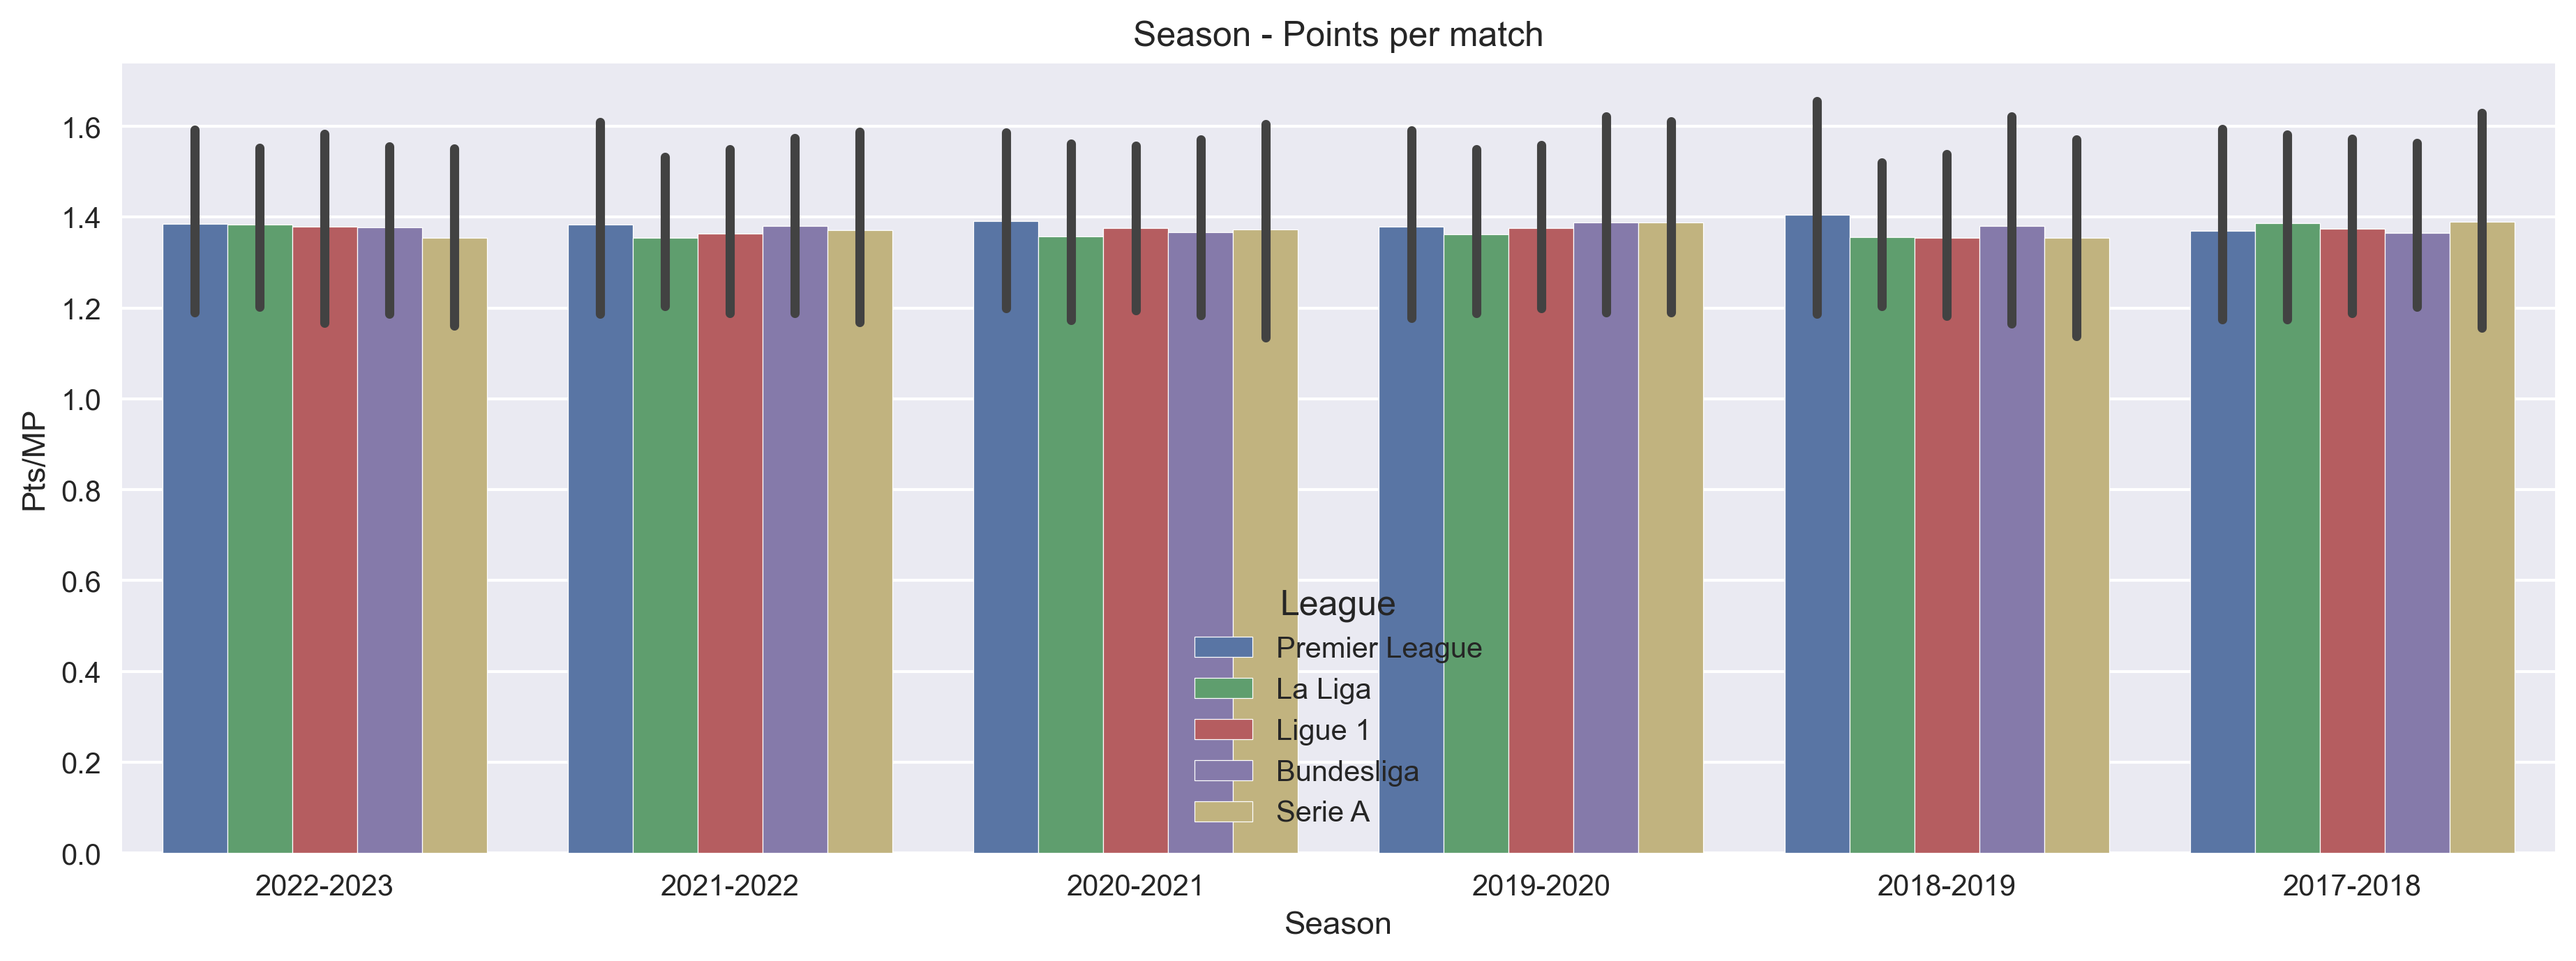

In [715]:
plt.figure(figsize=(15, 5), dpi=300)
sns.barplot(x='Season', y='Pts/MP', hue='League', data=df)
plt.title('Season - Points per match')
plt.show()

__Выводы:__
- Распределение очков по сезонам и годам примерно одинаково
- Про посещаемость то же самое сказать нельзя... Во-первых, сильно выделяется сезон 2020-2021 - это сезон, когда из-за ковидных ограничений в некоторых странах зрителей не пускали совсем. Можем заметить, что на втором ящике с усами этого года медиана равна нулю (или просто близка к нему, если учитывать репортеров как посетителей). Во-вторых, как мы видим из столбчатой диаграммы, распределение посещаемостей в сезоне 2021-2022 отличается от остальных - это довольно странно и непонятно...
- По ящику с усами кажется, что посещаемость в первом рассматриваемом сезоне (2017-2018) не отличается от посещаемости в последнем (2022-2023). Хочется потом проверить гипотезу о равенстве мат. ожиданий!

Последнее, что хотим посмотреть, - это соотношение различных показателей у вылетевших команд и всех остальных. 
<br> <br>
Будем использовать признаки:
- владение мячом (%)
- количество кроссов за игру
- количество фолов за игру
- посещаемость

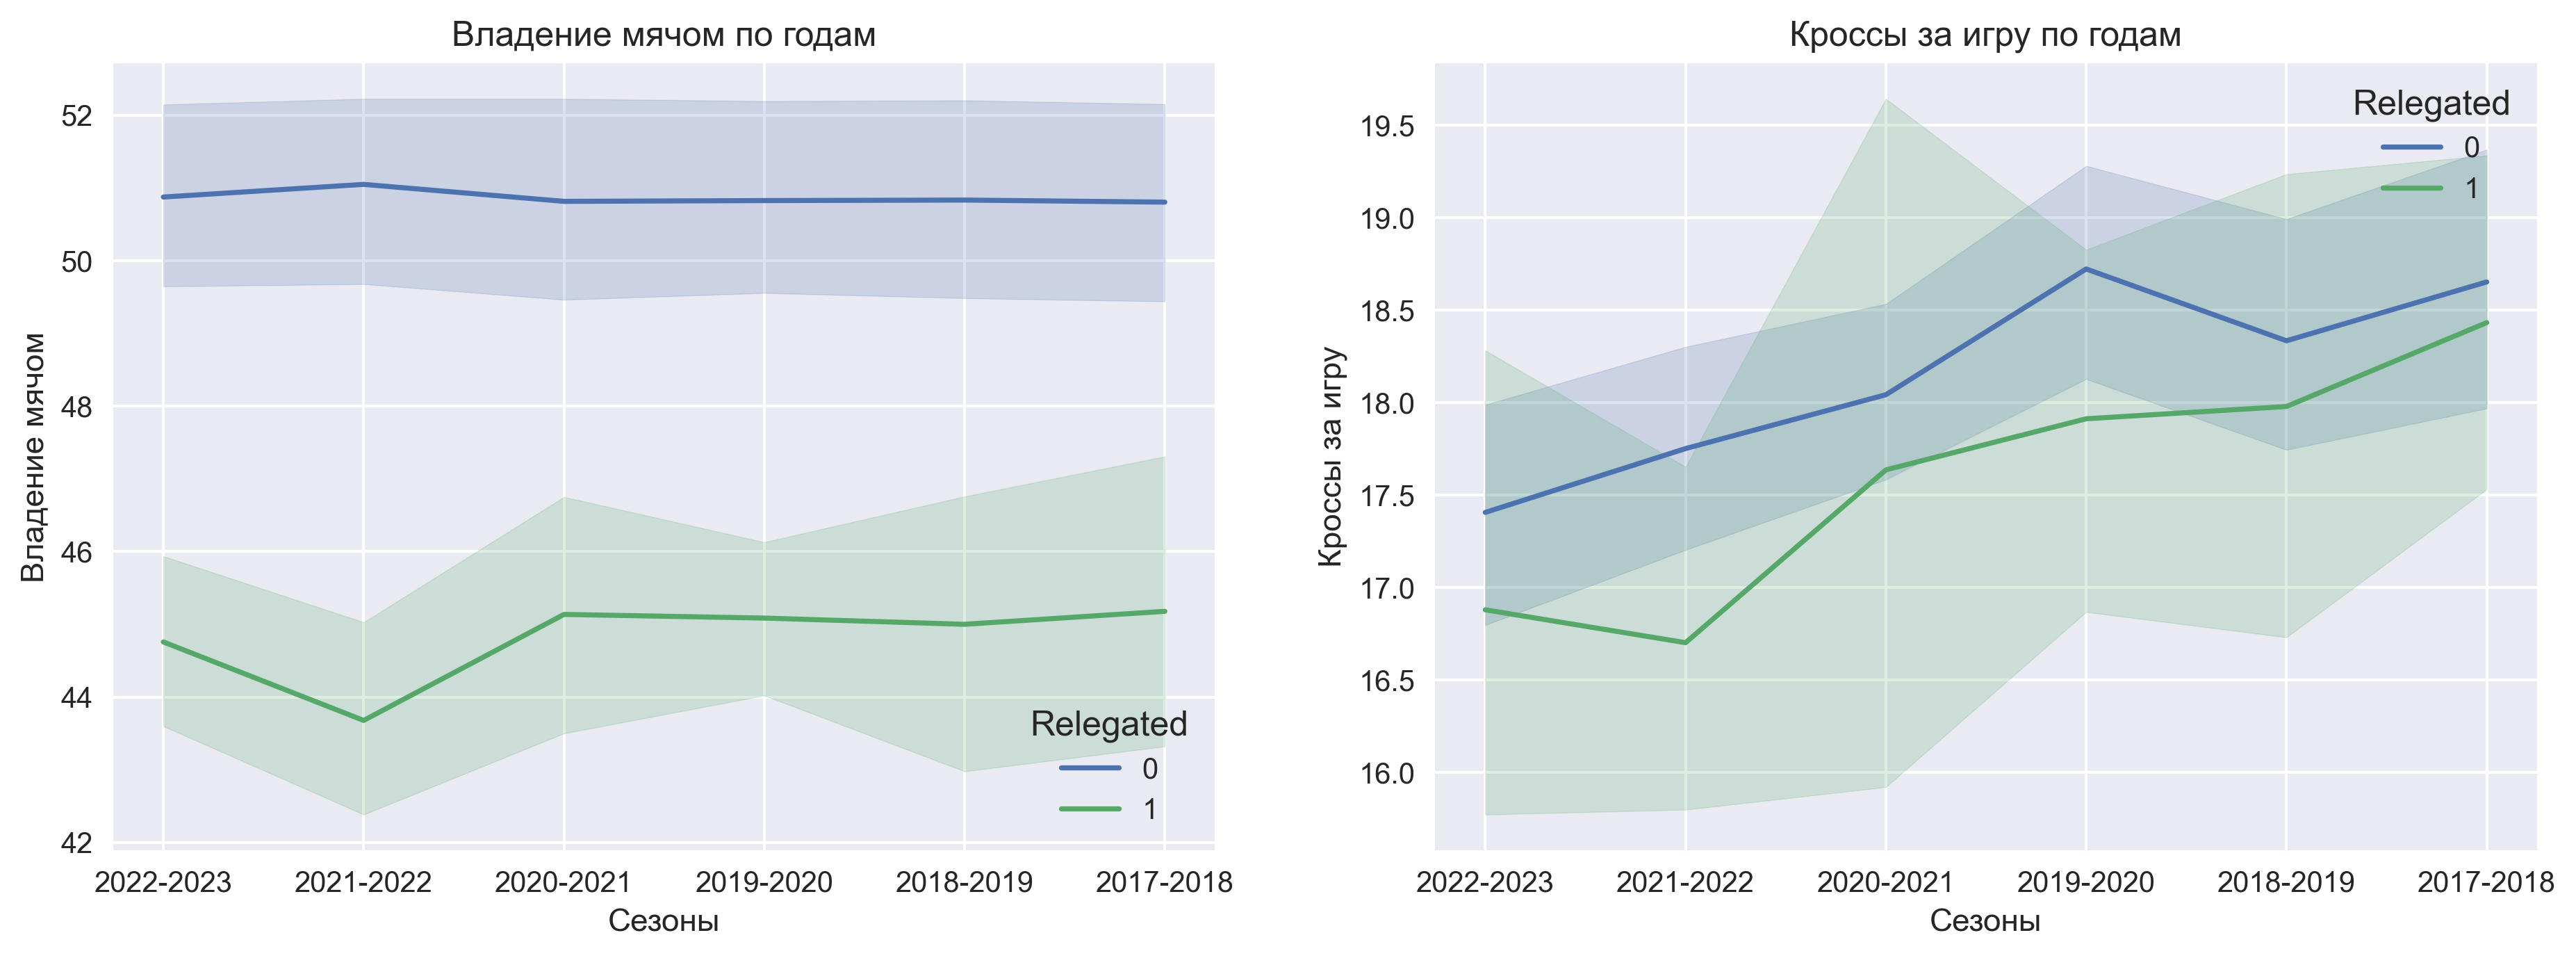

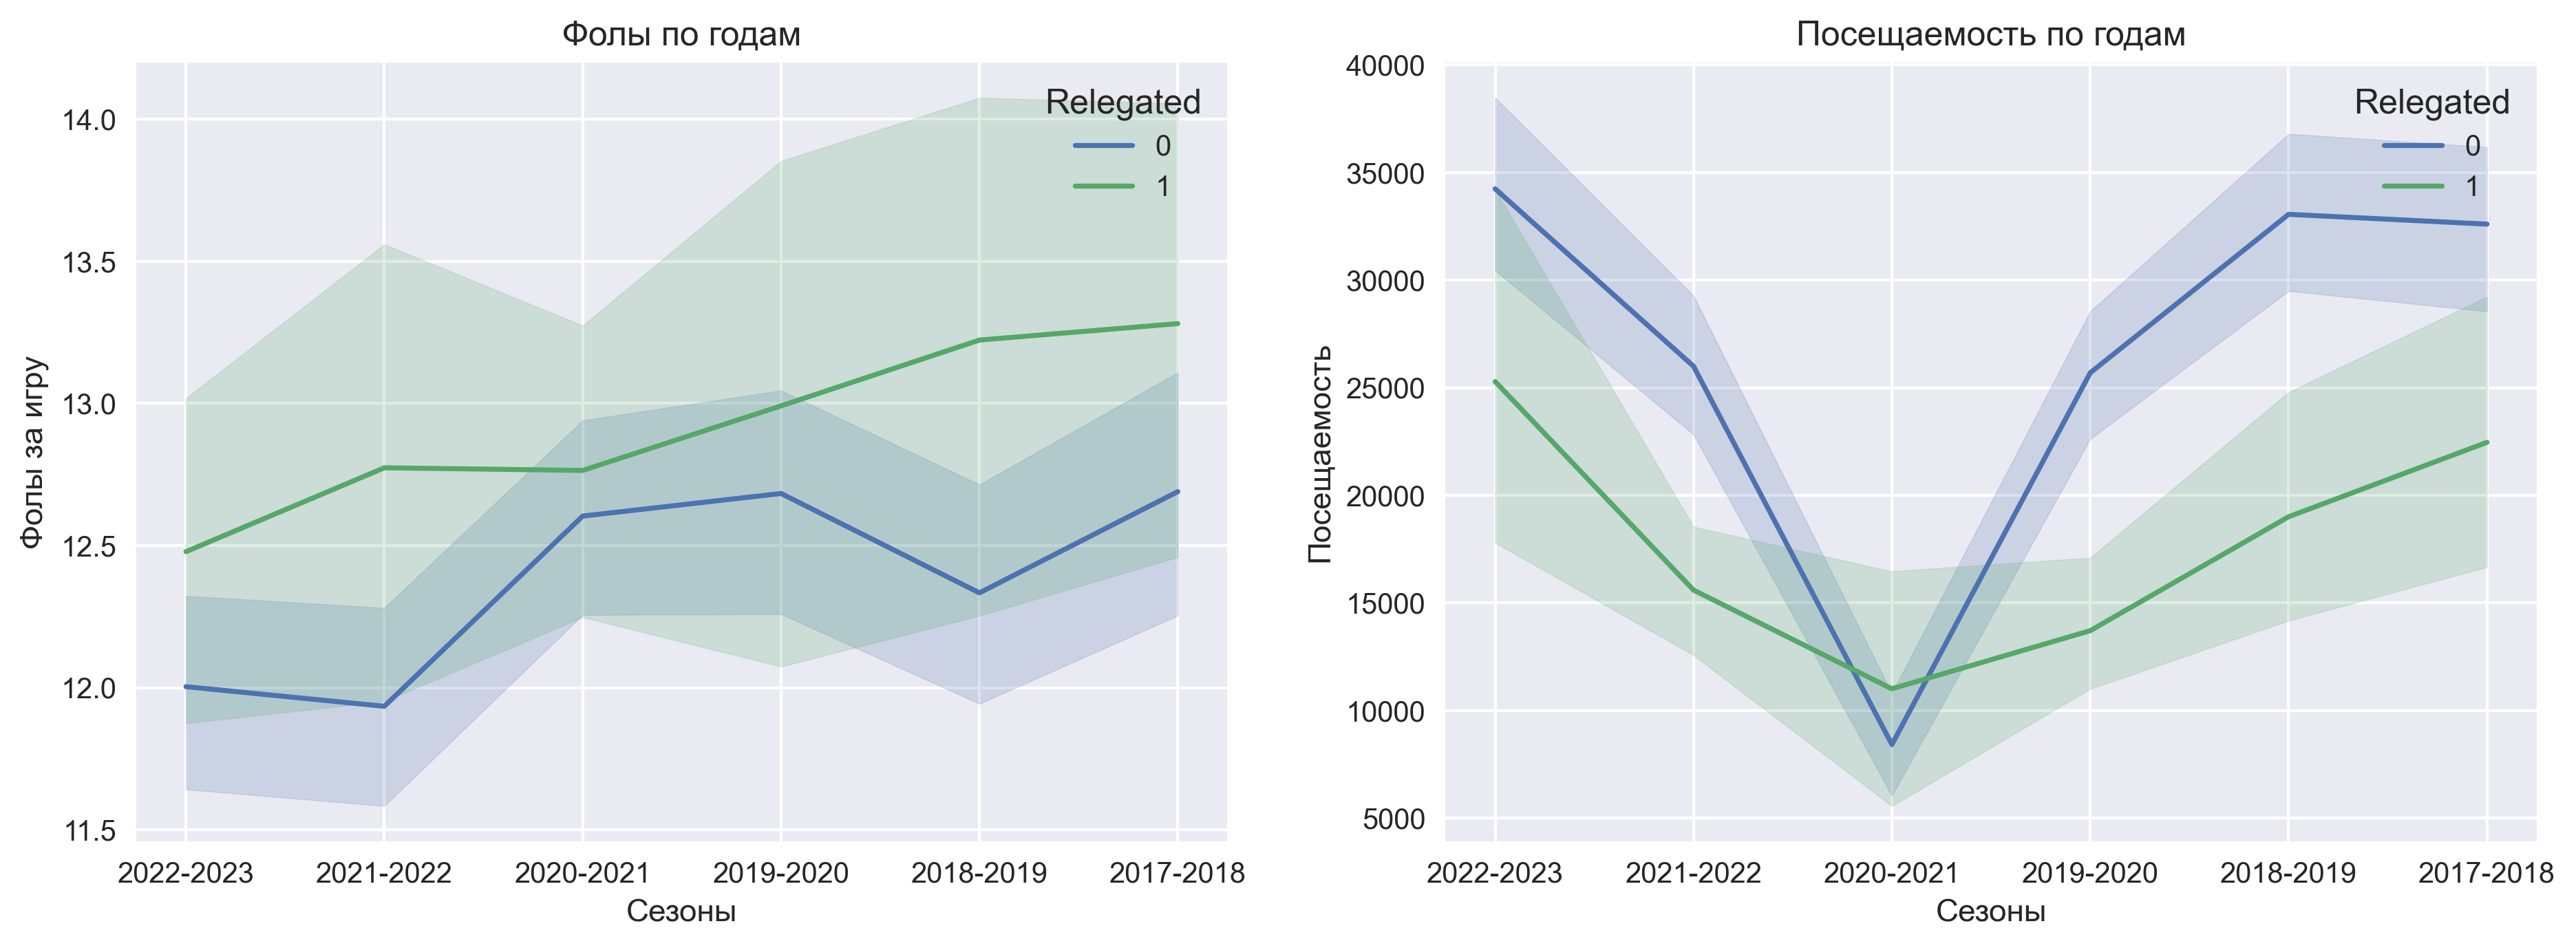

In [716]:
plt.figure(figsize=(15, 5), dpi=300)
plt.subplot(1, 2, 1)
plt.title('Владение мячом по годам')
sns.lineplot(x="Season", y="Poss", hue="Relegated", markers=True, data=df)
plt.xlabel('Сезоны')
plt.ylabel('Владение мячом');

plt.subplot(1, 2, 2)
plt.title('Кроссы за игру по годам')
sns.lineplot(x="Season", y="Pass Types: Crs (per game)", hue="Relegated", markers=True, data=df)
plt.xlabel('Сезоны')
plt.ylabel('Кроссы за игру');

plt.figure(figsize=(15, 5), dpi=300)
plt.subplot(1, 2, 1)
plt.title('Фолы по годам')
sns.lineplot(x="Season", y="Performance: Fls (per game)", hue="Relegated", markers=True, data=df)
plt.xlabel('Сезоны')
plt.ylabel('Фолы за игру');

plt.subplot(1, 2, 2)
plt.title('Посещаемость по годам')
sns.lineplot(x="Season", y="Attendance", hue="Relegated", markers=True, data=df)
plt.xlabel('Сезоны')
plt.ylabel('Посещаемость');

__Выводы:__
- Владение мячом у вылетевших команд меньше примерно на 6 процентных пунктов - отличие статистически значимо!
- Количество кроссов за игру по годам для вылетевших и невылетевших команд отличаются незначительно.
- Количество фоллов по годам больше у вылетевших команд, но отличие все же не статистически значимо.
- Посещаемость у вылетевших команд меньше примерно на 10000, что логично, поскольку людям скучно смотреть на матчи проигрывающих команд.
- В год ковида посещаемость у невылетевших команд упала сильнее, чем у вылетевших, что интересно.
- Кажется, что больше всех из рассмотренных признаков вылету способствует низкий процент владения мячом. Хочется построить модель классификации, которая будет предсказывать "понижение в классе" и посмотреть, какие признаки на самом деле самые важные. Потом можно будет даже вынести некоторые рекомендации для команд!